## Project the Population Receptive Field into the visual field

In [1]:
# Import the necessary modules
import cortex
import cortex.polyutils
import sys
import numpy as np
import os
opj = os.path.join
from prfpy.fit import Iso2DGaussianFitter, Fitter, Extend_Iso2DGaussianFitter
import neuropythy
from neuropythy import as_retinotopy
from matplotlib import cm
import pickle
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
import pandas as pd
from scipy.stats import pearsonr, mannwhitneyu
import ast

In [2]:
# Set up the directories and parameters
subjectid='sub-02'
subject = subjectid
atlas = 'manual'
depth='GM'
project='PROJECT_EGRET-AAA'
denoising='nordic'
MAIN_PATH=f'/Volumes/FedericaCardillo/pre-processing/projects/{project}/derivatives'
model_name='nelder-mead'
space='fsnative'
roi=['all']
r2_thr=0.1 
fs_dirPATH=f'{MAIN_PATH}/freesurfer'
task = 'RET'
grid = 70 
field_of_view = 7
save_dir = "/Users/federicacardillo/Desktop/EGRET-AAA/pRFmapping/heatmap"
glaucoma = ['sub-02', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08','sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-48'] # Missing 08 and 19
controls = ['sub-21', 'sub-22', 'sub-23', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29', 'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37', 'sub-38', 'sub-39', 'sub-40', 'sub-41', 'sub-42','sub-43', 'sub-44','sub-45','sub-46']
all_subjects = glaucoma + controls

In [3]:
# Load the surface and vertices of the subject
surfs = [cortex.polyutils.Surface(*d) for d in cortex.db.get_surf(subject, "fiducial")]
numel_left = surfs[0].pts.shape[0]
numel_right = surfs[1].pts.shape[0]
numel = numel_left + numel_right

idx_rois1, idx_vls1 = cortex.freesurfer.get_label(subject, label='benson14_eccen-0001', fs_dir=fs_dirPATH, hemisphere=('lh', 'rh'), verbose=True)
idx_rois2, idx_vls2 = cortex.freesurfer.get_label(subject, label='benson14_angle-0001', fs_dir=fs_dirPATH, hemisphere=('lh', 'rh'), verbose=True)
idx_rois3, idx_vls3 = cortex.freesurfer.get_label(subject, label='benson14_sigma-0001', fs_dir=fs_dirPATH, hemisphere=('lh', 'rh'), verbose=True)
idx_rois4, idx_vls4 = cortex.freesurfer.get_label(subject, label='benson14_varea-0001', fs_dir=fs_dirPATH, hemisphere=('lh', 'rh'), verbose=True)
if atlas=='manual':
    idx_rois5, idx_vls5 = cortex.freesurfer.get_label(subject, label='manualdelin', fs_dir=fs_dirPATH, hemisphere=('lh','rh'), verbose=True)
    idx_vls4[idx_rois5]=idx_vls5
    
idx_vls2[numel_left:]=-idx_vls2[numel_left:]
data=(idx_vls2,idx_vls1)
data=as_retinotopy(data, output_style='standard')
idx_vls2=data[0][:]

# Load the pRF mapping parameters 
test_file=opj(f'{MAIN_PATH}/pRFM/{subject}/ses-02/{denoising}/', f'model-{atlas}-{model_name}-{depth}_desc-prf_params_{task}.pkl')
with open(test_file, 'rb') as input:
    pkl_data = pickle.load(input)
prf_params=pkl_data['model'].iterative_search_params
roi_verts=np.where(pkl_data['rois_mask']==1)
prf_params_vx=roi_verts[0]
gauss_fitter=pkl_data['model']
best_vx=np.where(gauss_fitter.iterative_search_params[:,-1]==gauss_fitter.iterative_search_params[:,-1].max())

looking for ['/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/lh.benson14_eccen-0001.label', '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/rh.benson14_eccen-0001.label']
looking for ['/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/lh.benson14_angle-0001.label', '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/rh.benson14_angle-0001.label']
looking for ['/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/lh.benson14_sigma-0001.label', '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/rh.benson14_sigma-0001.label']
looking for ['/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/lh.benson14_varea-0001.labe

### Heat map

In [4]:
# Generate the heatmaps for the control group and for each glaucoma subject 
def heatmap_controls(controls, group_name, MAIN_PATH, atlas, model_name, depth, denoising, task):
    all_x = []
    all_y = []
    all_sigma = []
    statistics = []  

    for subj in controls:
        try:
            prf_file = os.path.join(MAIN_PATH, f'pRFM/{subj}/ses-02/{denoising}/model-{atlas}-{model_name}-{depth}_desc-prf_params_{task}.pkl')
            with open(prf_file, 'rb') as f:
                pkl = pickle.load(f)
            params = pkl['model'].iterative_search_params
            x = params[:, 0]
            y = params[:, 1]
            sigma = params[:, 2]
            all_x.append(x)
            all_y.append(y)
            all_sigma.append(sigma)
            stat, _, _, _ = binned_statistic_2d(x, y, sigma, statistic='mean', bins=70, range=[[-7, 7], [-7, 7]])
            statistics.append(stat)
        except FileNotFoundError:
            continue

    if all_x:
        x = np.concatenate(all_x)
        y = np.concatenate(all_y)
        sigma = np.concatenate(all_sigma)

        plt.figure(figsize=(8, 6))
        sc = plt.scatter(x, y, marker='o', s=2, cmap='hot', c=sigma)
        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.colorbar(sc, label='pRF size')
        plt.title(f'pRF heatmap: {group_name}')
        plt.grid(True)
        os.makedirs("/Users/federicacardillo/Desktop/EGRET-AAA/pRFmapping/heatmap", exist_ok=True)
        plt.savefig(os.path.join("/Users/federicacardillo/Desktop/EGRET-AAA/pRFmapping/heatmap", f"controls_{task}_raw.jpg"))
        plt.show()

        stat, x_edges, y_edges, binnumber = binned_statistic_2d(x, y, sigma, statistic='mean', bins=70, range=[[-7, 7], [-7, 7]])
        plt.figure(figsize=(8, 6))
        plt.imshow(stat.T, origin='lower', extent=[-7, 7, -7, 7], aspect='equal', cmap='hot')
        plt.colorbar(label='Mean pRF size')
        plt.title(f'pRF heatmap (binned): {group_name}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid(False)
        plt.savefig(os.path.join("/Users/federicacardillo/Desktop/EGRET-AAA/pRFmapping/heatmap", f"controls_{task}_bin.jpg"))
        plt.show()

        statistics = np.array(statistics)
        mean_map = np.nanmean(statistics, axis=0)
        std_map = np.nanstd(statistics, axis=0)
        return mean_map, std_map
    else:
        return None, None

def heatmap_glaucoma(subjects, group_name, MAIN_PATH, save_dir, atlas, model_name, depth, denoising, task, mean_map, std_map):
    glaucoma_maps = {} 
    zscore_maps = {}

    for subj in subjects:
        prf_file = os.path.join(MAIN_PATH, f'pRFM/{subj}/ses-02/{denoising}/model-{atlas}-{model_name}-{depth}_desc-prf_params_{task}.pkl')
        try:
            with open(prf_file, 'rb') as f:
                pkl = pickle.load(f)
            params = pkl['model'].iterative_search_params
            x = params[:, 0]
            y = params[:, 1]
            sigma = params[:, 2]

            # Compute binned heatmap
            stat, _, _, _ = binned_statistic_2d(x, y, sigma, statistic='mean', bins=70, range=[[-7, 7], [-7, 7]])
            glaucoma_maps[subj] = stat

            # Save the raw pRF map heatmap
            plt.figure(figsize=(8, 6))
            plt.imshow(stat.T, origin='lower', extent=[-7, 7, -7, 7], aspect='equal', cmap='hot')
            plt.colorbar(label='Mean pRF size')
            plt.title(f'{group_name}: {subj}')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.grid(False)
            plt.savefig(os.path.join(save_dir, f"{group_name.lower()}_{subj}_{task}_bin.jpg"))
            plt.close()

            # Compute and store z-score map
            with np.errstate(divide='ignore', invalid='ignore'):
                zmap = (stat - mean_map) / std_map
                zmap[np.isnan(zmap)] = 0
            zscore_maps[subj] = zmap

            # Save z-map visualization
            plt.figure(figsize=(8, 6))
            plt.imshow(zmap.T, origin='lower', extent=[-7, 7, -7, 7], aspect='equal', cmap='bwr', vmin=-3, vmax=3)
            plt.colorbar(label='Z-score deviation')
            plt.title(f'Z-score map: {subj}')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.grid(False)
            plt.savefig(os.path.join(save_dir, f"zmap_{subj}_{task}.jpg"))
            plt.close()

        except FileNotFoundError:
            print(f"File not found for {subj}")

    return glaucoma_maps, zscore_maps

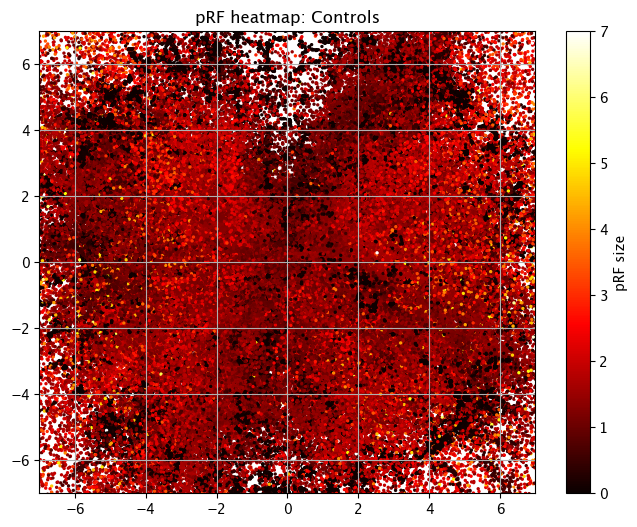

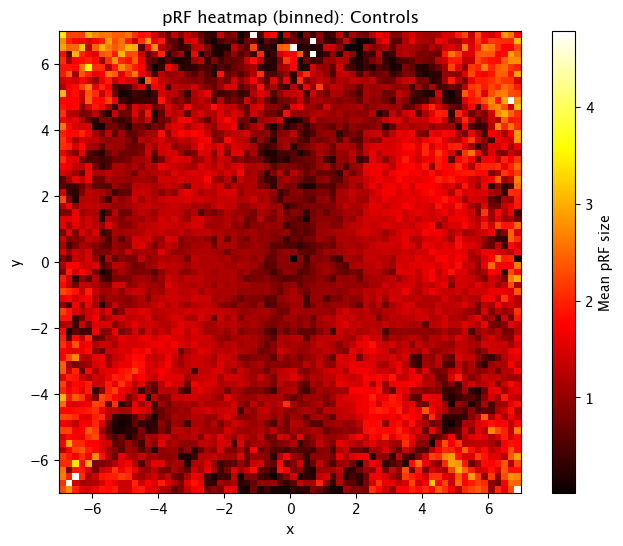

/var/folders/0k/zjsxn2197mdbzvx14lj8m0v00000gn/T/ipykernel_83673/997645099.py:53: RuntimeWarning: Mean of empty slice
  mean_map = np.nanmean(statistics, axis=0)
/Users/federicacardillo/Downloads/y/envs/pRFfitting/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [5]:
mean_map, std_map = heatmap_controls(controls, 'Controls', MAIN_PATH, atlas, model_name, depth, denoising, task)
glaucoma_maps, zscore_maps = heatmap_glaucoma(glaucoma, 'Glaucoma', MAIN_PATH, save_dir, atlas, model_name, depth, denoising, task, mean_map, std_map)

In [6]:
## Add this to the main heatmap_glaucoma
def compute_quadrant_deviation_scores(zscore_maps, threshold=2):
    quadrant_scores = {}

    for subj, zmap in zscore_maps.items():
        abs_zmap = np.abs(zmap)

        # Quadrants
        UL = abs_zmap[35:70, 0:35]
        UR = abs_zmap[35:70, 35:70]
        DL = abs_zmap[0:35, 0:35]
        DR = abs_zmap[0:35, 35:70]
        # Count abnormal bins per quadrant
        quadrant_scores[subj] = {'UL': np.sum(UL > threshold), 'UR': np.sum(UR > threshold), 'DL': np.sum(DL > threshold), 'DR': np.sum(DR > threshold),}

    return quadrant_scores

quadrant_scores = compute_quadrant_deviation_scores(zscore_maps)

In [12]:
#ANALYSIS A: Does the pRF size per quadrant per visual area (V1, V2, V3) differ for each patient compared to the normative group
def extract_heatmap_quadrant_prf(grid=70):
    """
    Extract average pRF size (sigma) per quadrant and per visual area, per subject.
    Uses subject-specific visual area label masks.
    """
    quadrant_coords = {
        'UL': (slice(35, 70), slice(0, 35)),
        'UR': (slice(35, 70), slice(35, 70)),
        'DL': (slice(0, 35), slice(0, 35)),
        'DR': (slice(0, 35), slice(35, 70)),
    }
    varea_map = {1: 'V1', 2: 'V2', 3: 'V3'}
    heatmap_data = {}

    for subj in glaucoma + controls:
        try:
            # Load pRF data
            prf_file = os.path.join(MAIN_PATH, f'pRFM/{subj}/ses-02/{denoising}/model-{atlas}-{model_name}-{depth}_desc-prf_params_{task}.pkl')
            with open(prf_file, 'rb') as f:
                data = pickle.load(f)
            params = data['model'].iterative_search_params
            x, y, sigma = params[:, 0], params[:, 1], params[:, 2]
            rois_mask = data['rois_mask']
            valid_voxels = np.where(rois_mask == 1)[0]

            # Load visual area label file per subject
            label_file = os.path.join(fs_dirPATH, subj, 'label', f'benson14_varea-0001.label')
            idx_rois, idx_vls = cortex.freesurfer.get_label(subj, label='benson14_varea-0001',
                                                            fs_dir=fs_dirPATH, hemisphere=('lh', 'rh'), verbose=False)
            # Create a visual area label array of same size as prf_params
            varea_full = np.zeros_like(rois_mask, dtype=int)
            varea_full[idx_rois] = idx_vls
            varea = varea_full[valid_voxels]  # aligned to prf_params

            subj_data = {}
            for vnum, vname in varea_map.items():
                area_indices = np.where(varea == vnum)[0]
                if len(area_indices) == 0:
                    continue

                x_area = x[area_indices]
                y_area = y[area_indices]
                sigma_area = sigma[area_indices]

                stat, _, _, _ = binned_statistic_2d(
                    x_area, y_area, sigma_area, statistic='mean',
                    bins=grid, range=[[-7, 7], [-7, 7]]
                )

                quad_means = {}
                for quad, (xidx, yidx) in quadrant_coords.items():
                    region = stat[xidx, yidx]
                    quad_means[quad] = np.nanmean(region)
                subj_data[vname] = quad_means

            heatmap_data[subj] = subj_data

        except Exception as e:
            print(f"[ERROR] Heatmap quadrant extraction failed for {subj}: {e}")
            continue

    return heatmap_data

from scipy.stats import zscore


In [14]:

def analyze_prf_quadrant_deviation(heatmap_data, controls, patients, z_thresh=2):
    """
    Compare patient pRF sizes per quadrant per visual area to normative group.
    
    Returns: DataFrame with columns:
        subject, area, quadrant, prf_size, zscore, deviation_class (-1, 0, 1)
    """
    results = []

    # Step 1: Compute normative means and stds from controls
    norm_stats = {}
    for area in ['V1', 'V2', 'V3']:
        for quad in ['UL', 'UR', 'DL', 'DR']:
            vals = [
                heatmap_data[subj][area][quad]
                for subj in controls
                if subj in heatmap_data and area in heatmap_data[subj]
                and quad in heatmap_data[subj][area]
                and not np.isnan(heatmap_data[subj][area][quad])
            ]
            if vals:
                norm_stats[(area, quad)] = {
                    'mean': np.mean(vals),
                    'std': np.std(vals)
                }

    # Step 2: Compare each patient to the normative group
    for subj in patients:
        if subj not in heatmap_data:
            continue

        for area in ['V1', 'V2', 'V3']:
            if area not in heatmap_data[subj]:
                continue

            for quad in ['UL', 'UR', 'DL', 'DR']:
                prf_val = heatmap_data[subj][area].get(quad, np.nan)
                norm = norm_stats.get((area, quad), None)
                if norm is None or np.isnan(prf_val):
                    continue

                mean, std = norm['mean'], norm['std']
                z = (prf_val - mean) / std if std > 0 else 0
                classification = -1 if z < -z_thresh else (1 if z > z_thresh else 0)

                results.append({
                    'subject': subj,
                    'area': area,
                    'quadrant': quad,
                    'prf_size': prf_val,
                    'zscore': z,
                    'deviation_class': classification
                })

    return pd.DataFrame(results)

analysis_a_df = analyze_prf_quadrant_deviation(
    heatmap_data=extract_heatmap_quadrant_prf(grid=grid),
    controls=controls,
    patients=glaucoma,
    z_thresh=2)

looking for ['/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/lh.benson14_varea-0001.label', '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/rh.benson14_varea-0001.label']
looking for ['/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-04/label/lh.benson14_varea-0001.label', '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-04/label/rh.benson14_varea-0001.label']
looking for ['/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-05/label/lh.benson14_varea-0001.label', '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-05/label/rh.benson14_varea-0001.label']
looking for ['/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-06/label/lh.benson14_varea-0001.labe

    subject area quadrant  prf_size    zscore  deviation_class
0    sub-02   V1       UL  0.823092 -0.811545                0
1    sub-02   V1       UR  0.635845 -1.130771                0
2    sub-02   V1       DL  1.046084  0.004451                0
3    sub-02   V1       DR  0.934258  0.036770                0
4    sub-02   V2       UL  0.975652 -0.544398                0
..      ...  ...      ...       ...       ...              ...
223  sub-48   V2       DR  1.063850  0.231286                0
224  sub-48   V3       UL  1.072412 -0.387527                0
225  sub-48   V3       UR  0.549549 -2.797532               -1
226  sub-48   V3       DL  0.458583 -2.569519               -1
227  sub-48   V3       DR  0.789793 -1.688769                0

[228 rows x 6 columns]


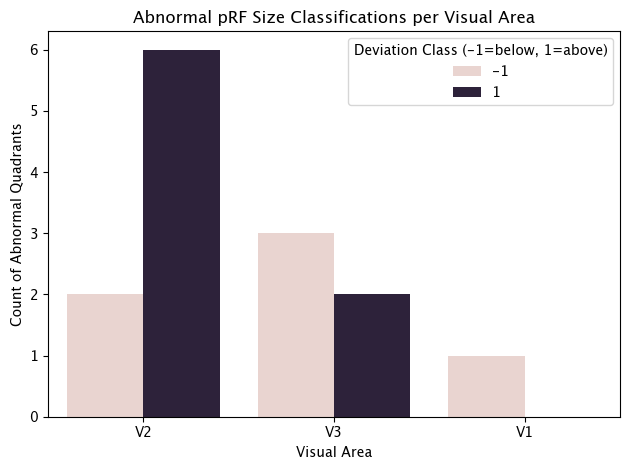

In [18]:
print(analysis_a_df)
analysis_a_df.to_csv("analysis_A_results.csv", index=False)
analysis_a_df

sig_deviations = analysis_a_df[analysis_a_df["deviation_class"] != 0]
analysis_a_df.groupby(['area', 'deviation_class']).size()
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=analysis_a_df[analysis_a_df.deviation_class != 0],
              x='area', hue='deviation_class')
plt.title("Abnormal pRF Size Classifications per Visual Area")
plt.xlabel("Visual Area")
plt.ylabel("Count of Abnormal Quadrants")
plt.legend(title="Deviation Class (-1=below, 1=above)")
plt.tight_layout()
plt.show()

### Coverage map

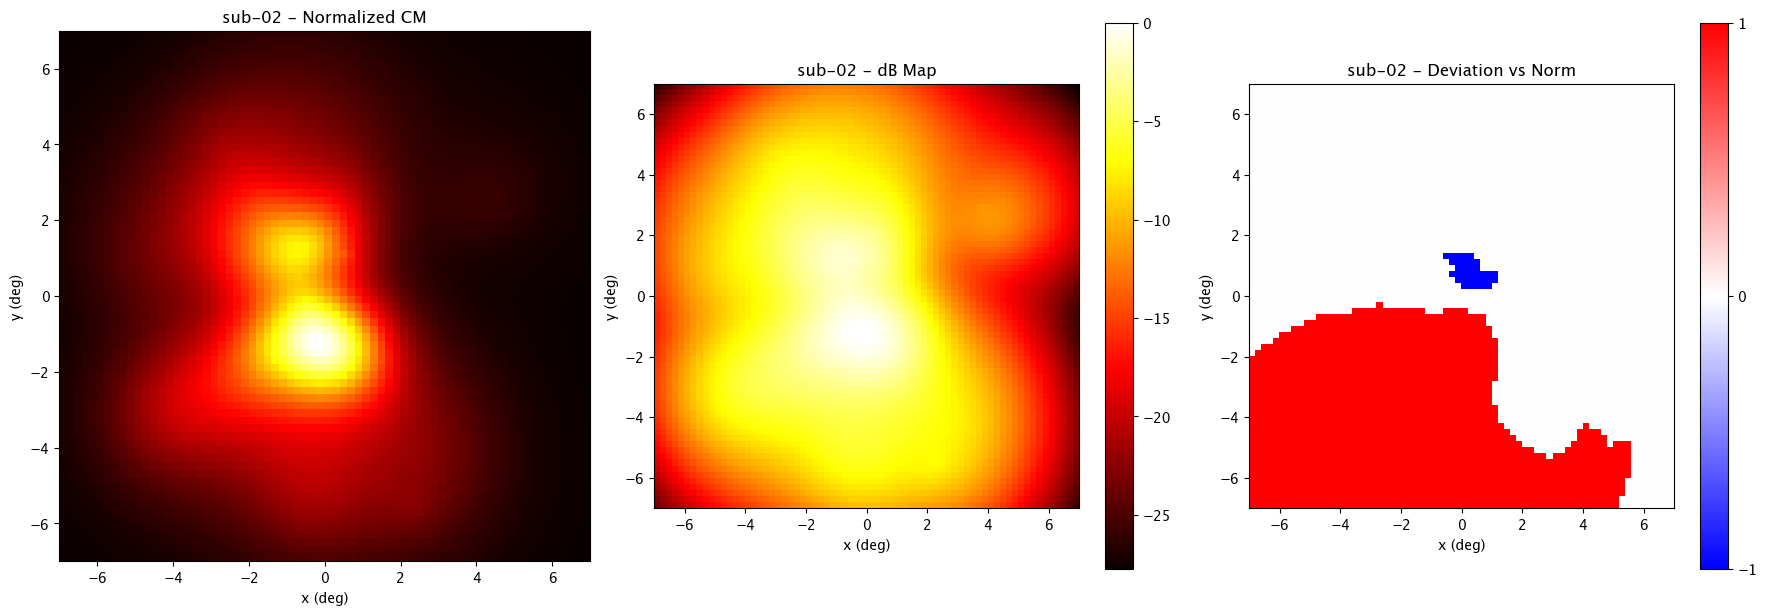

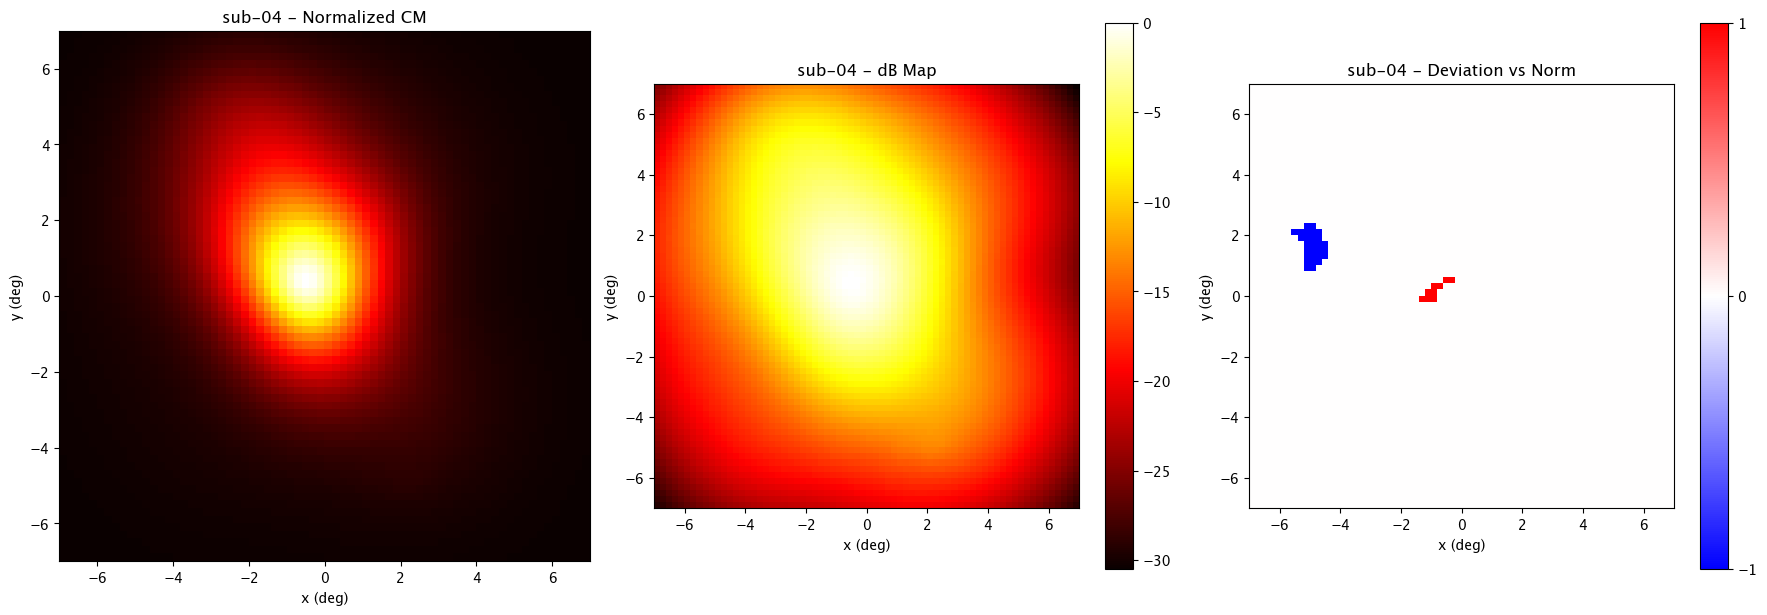

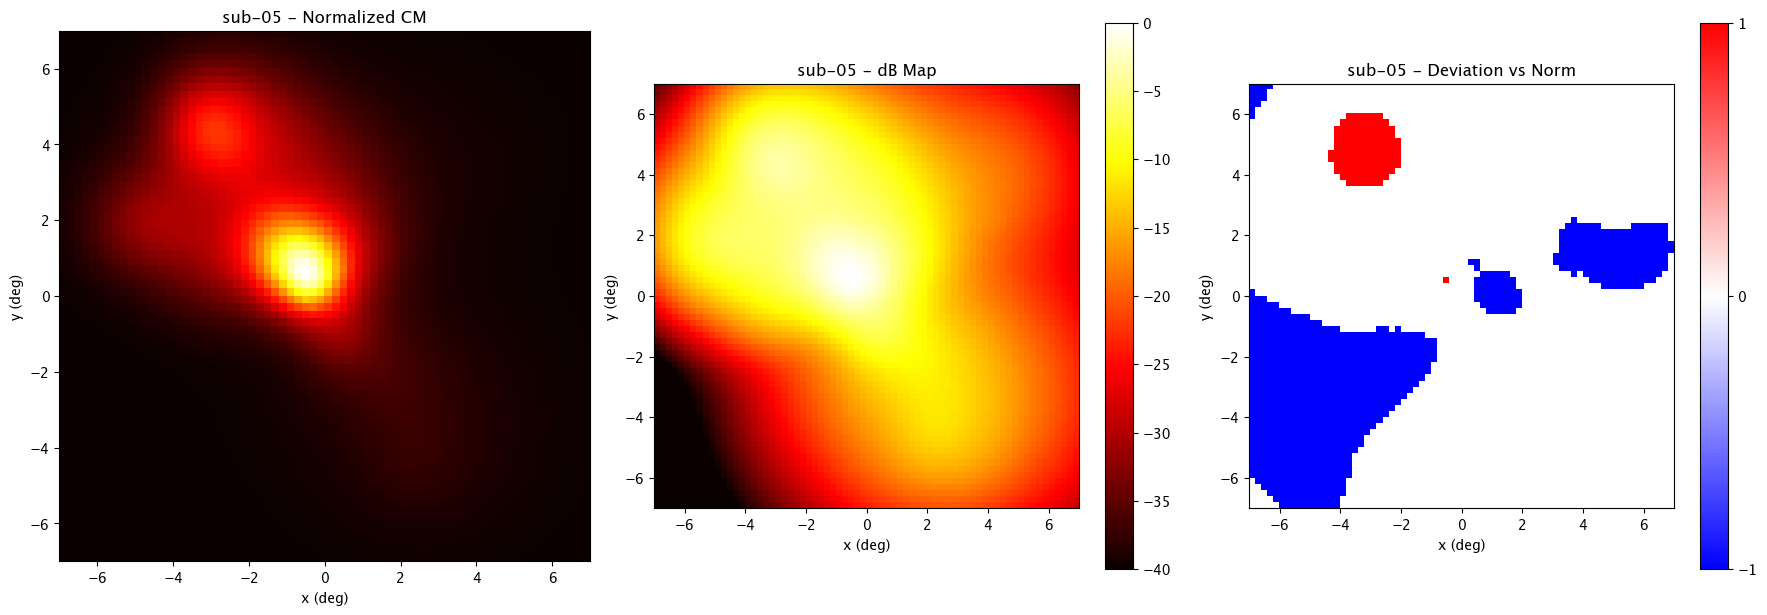

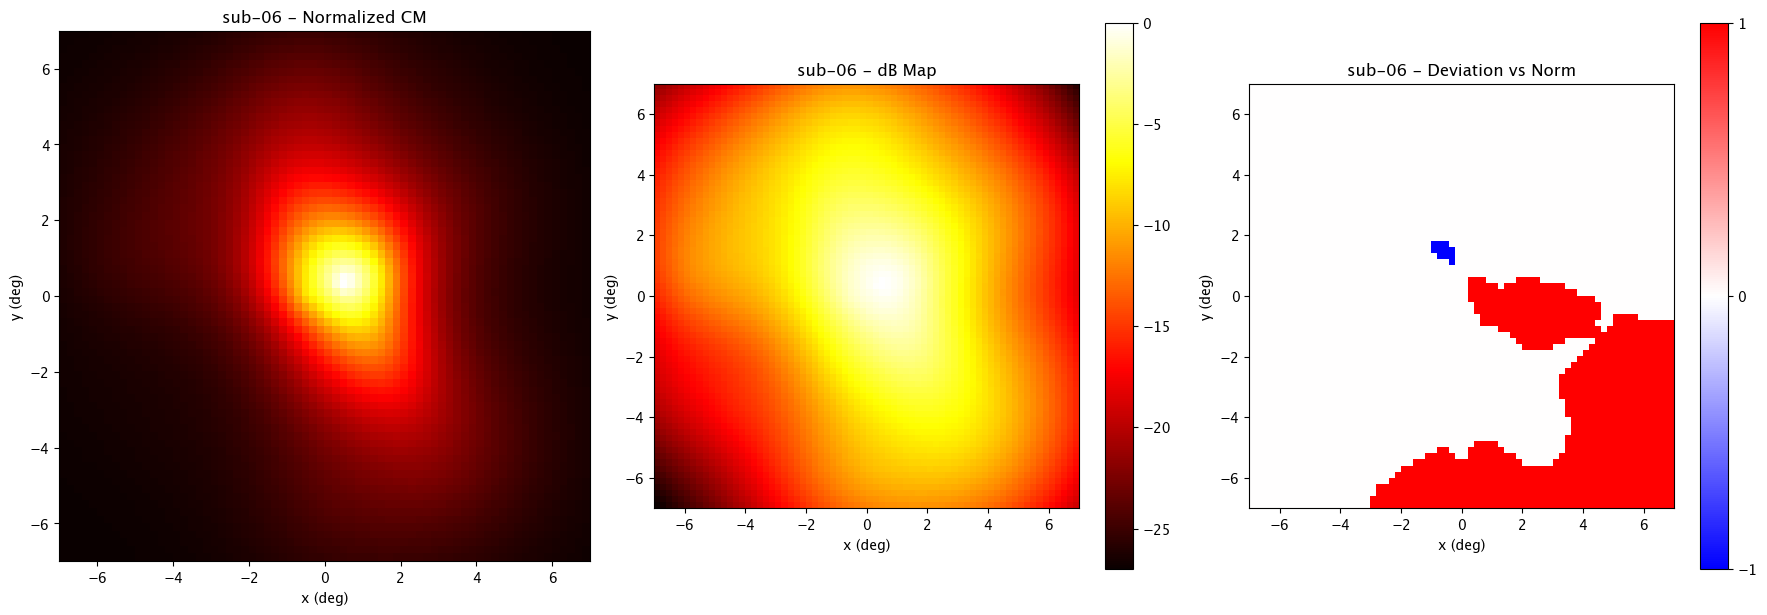

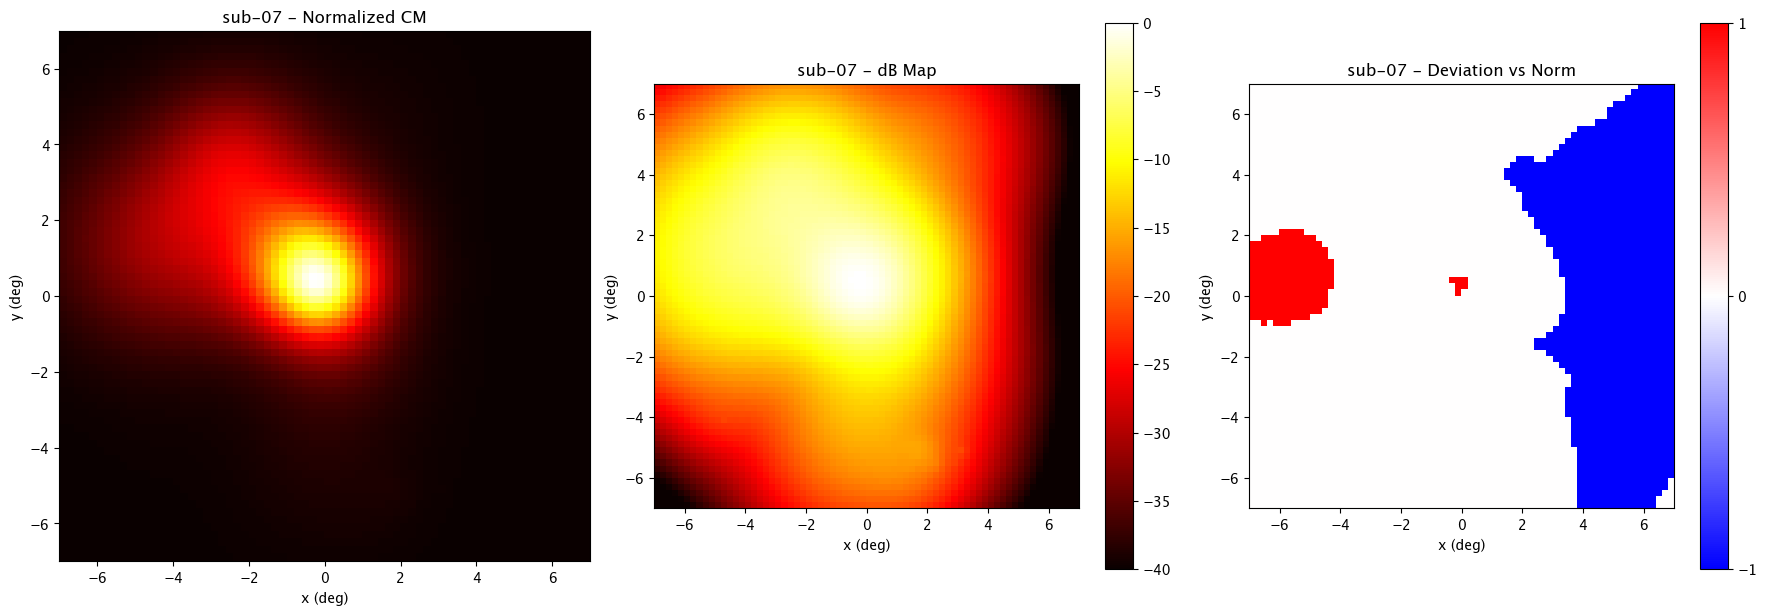

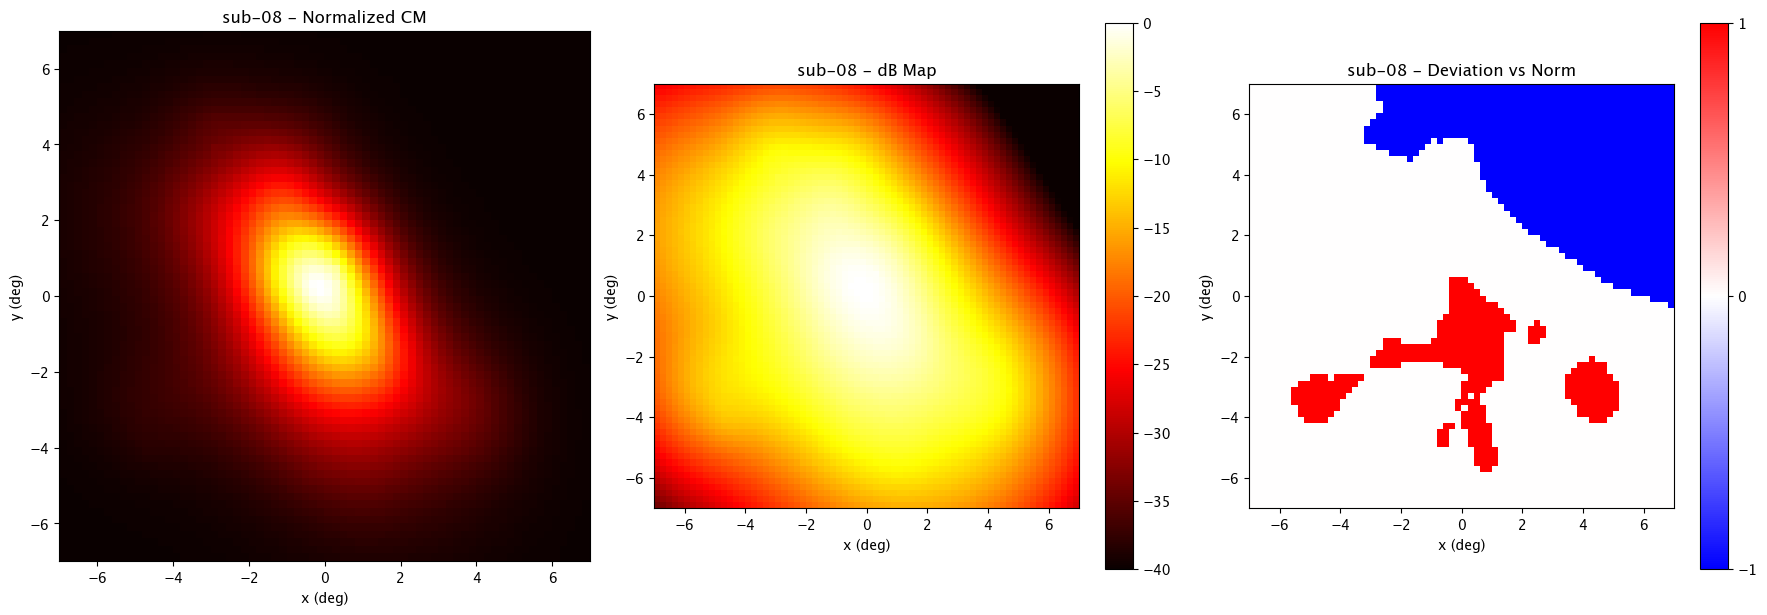

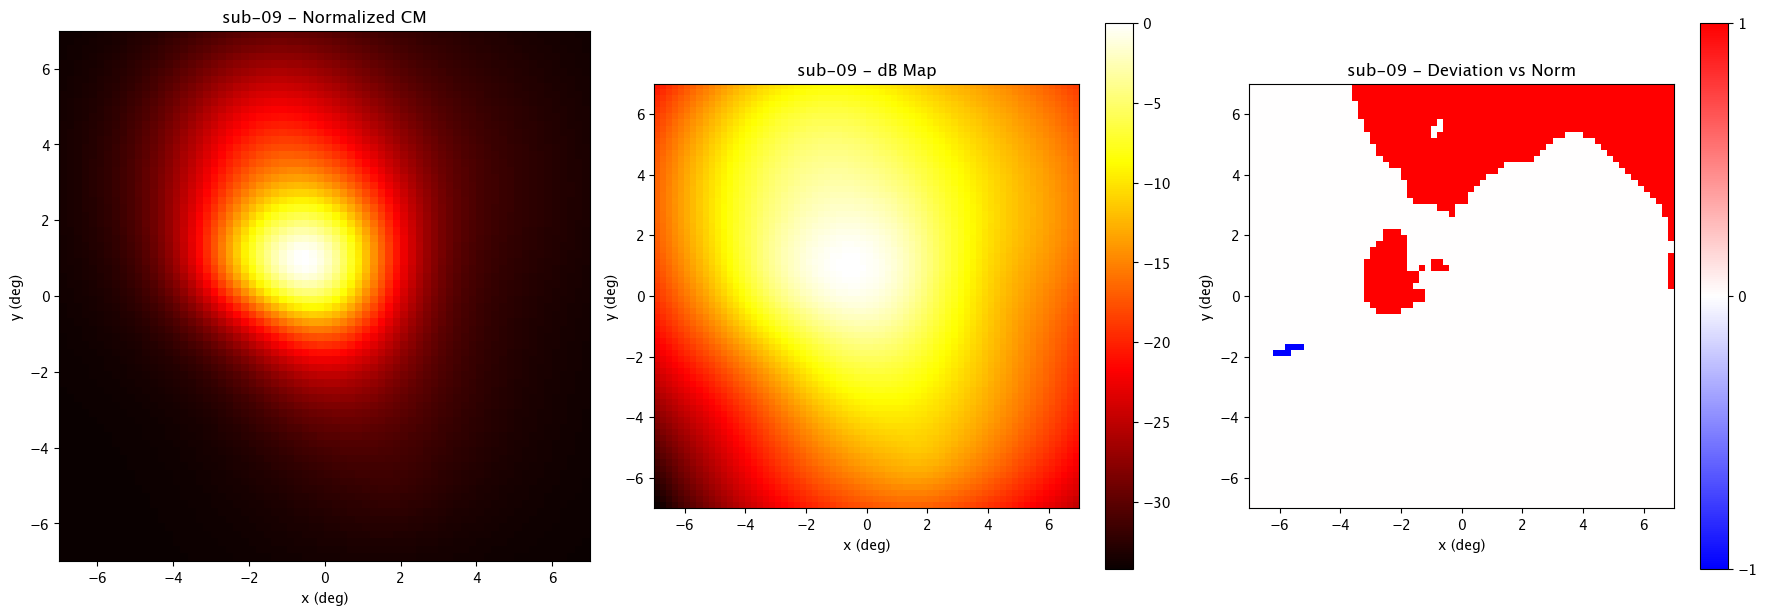

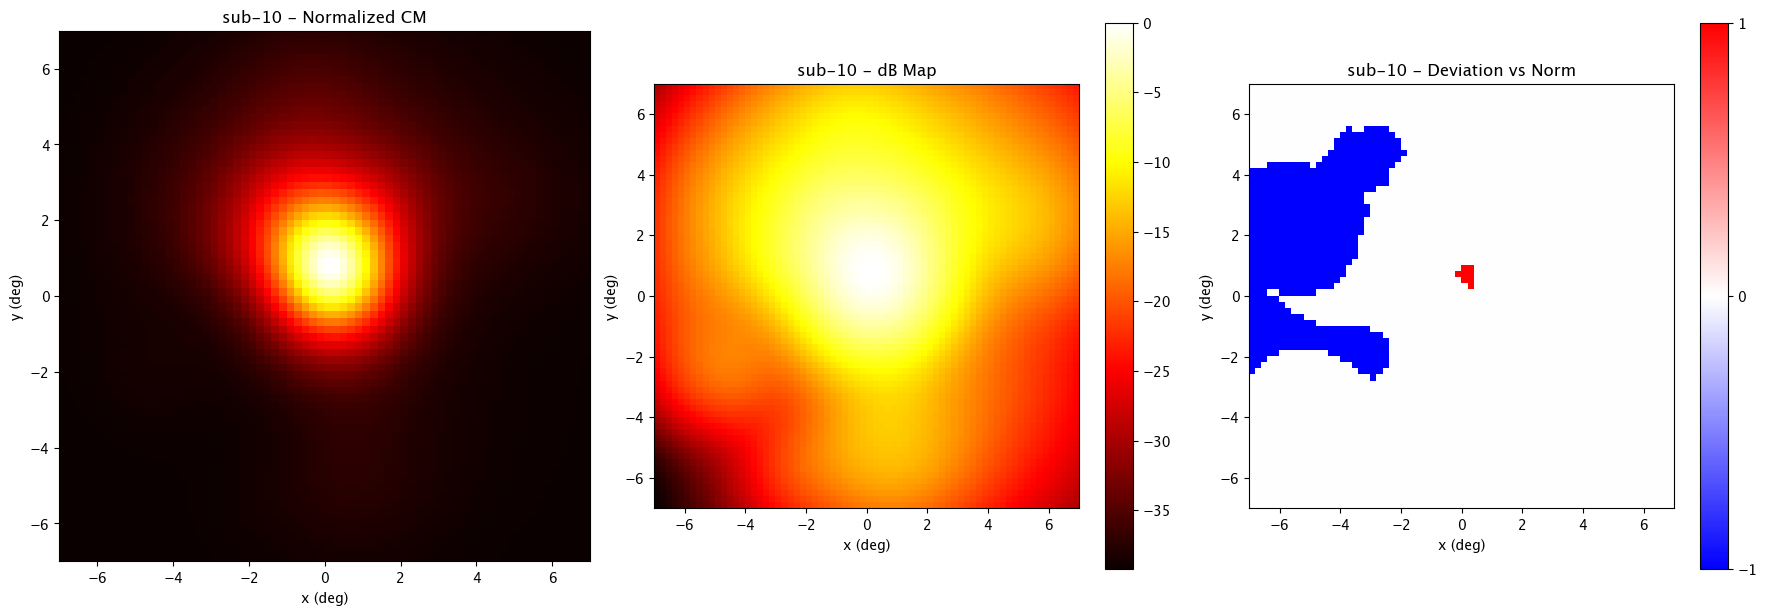

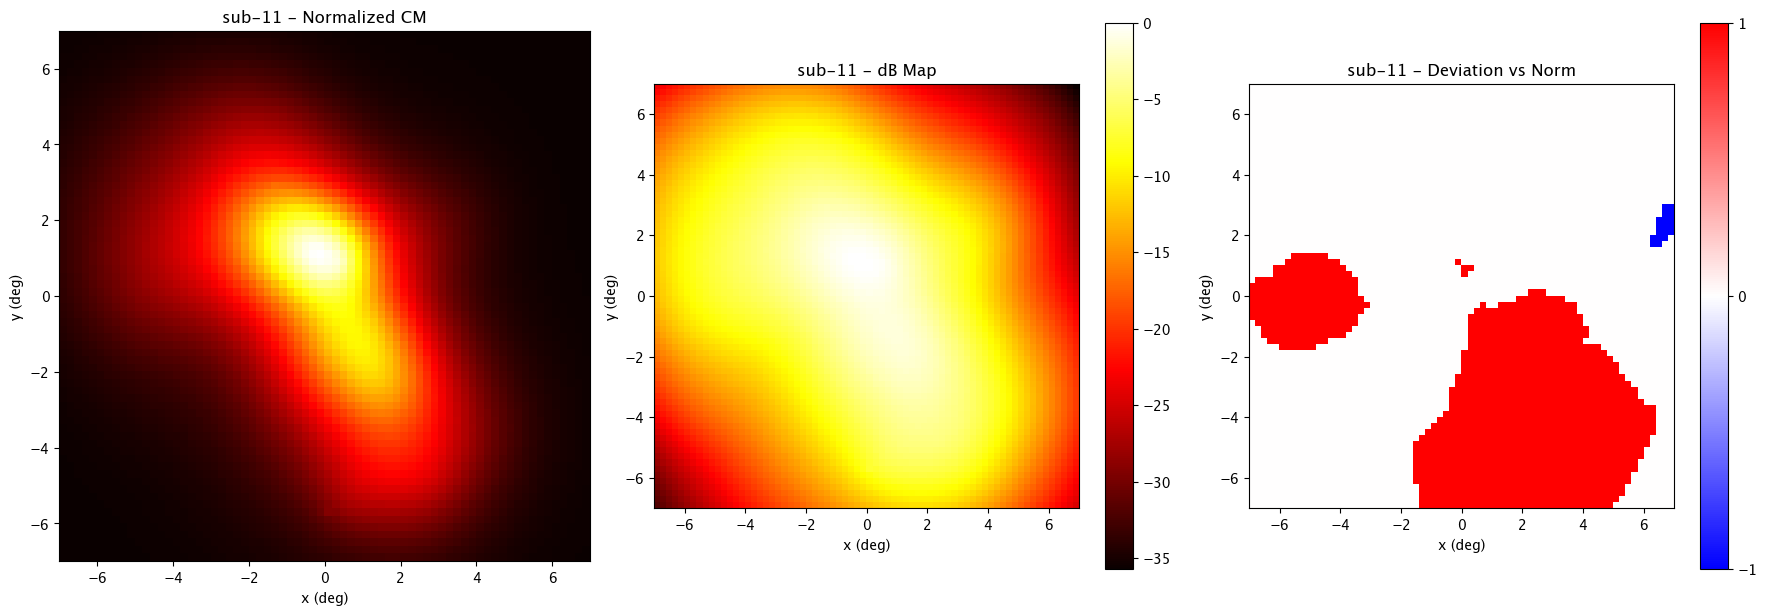

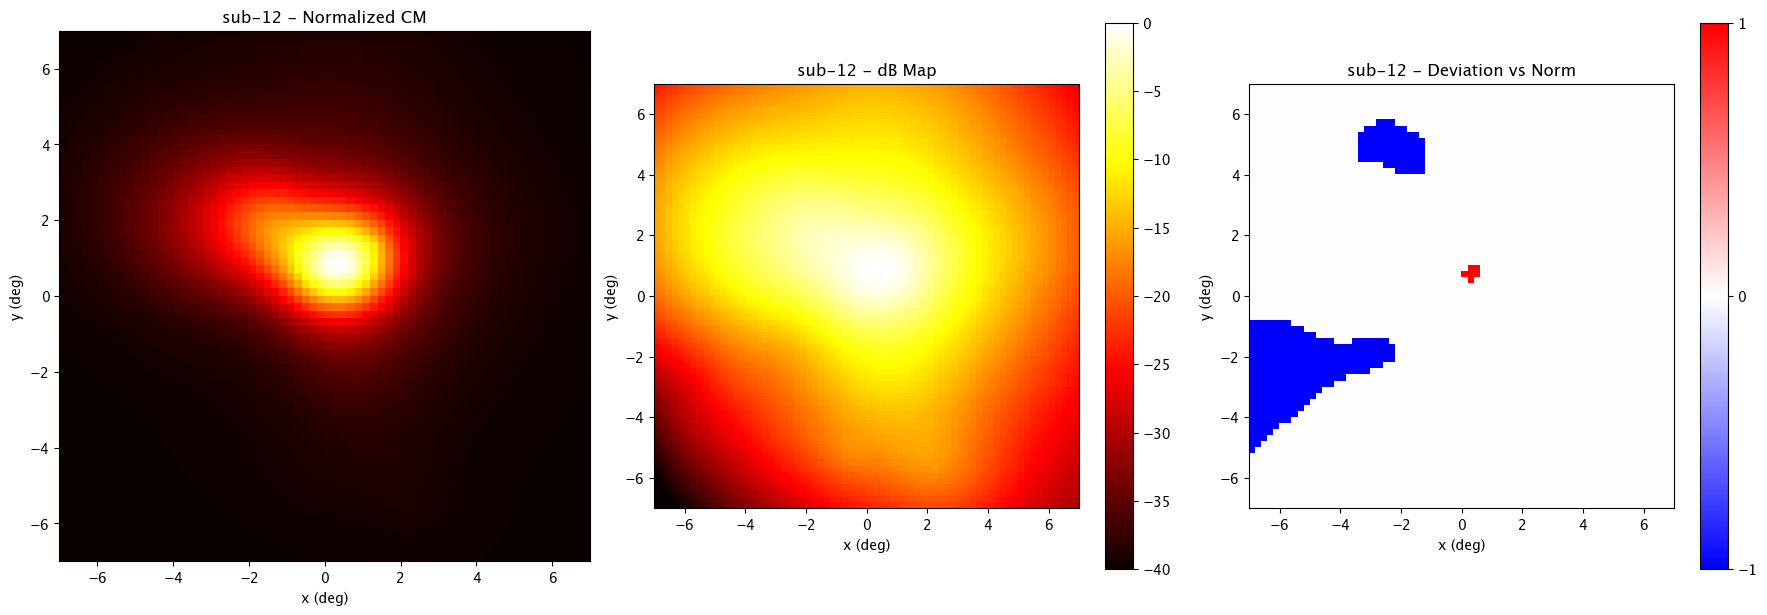

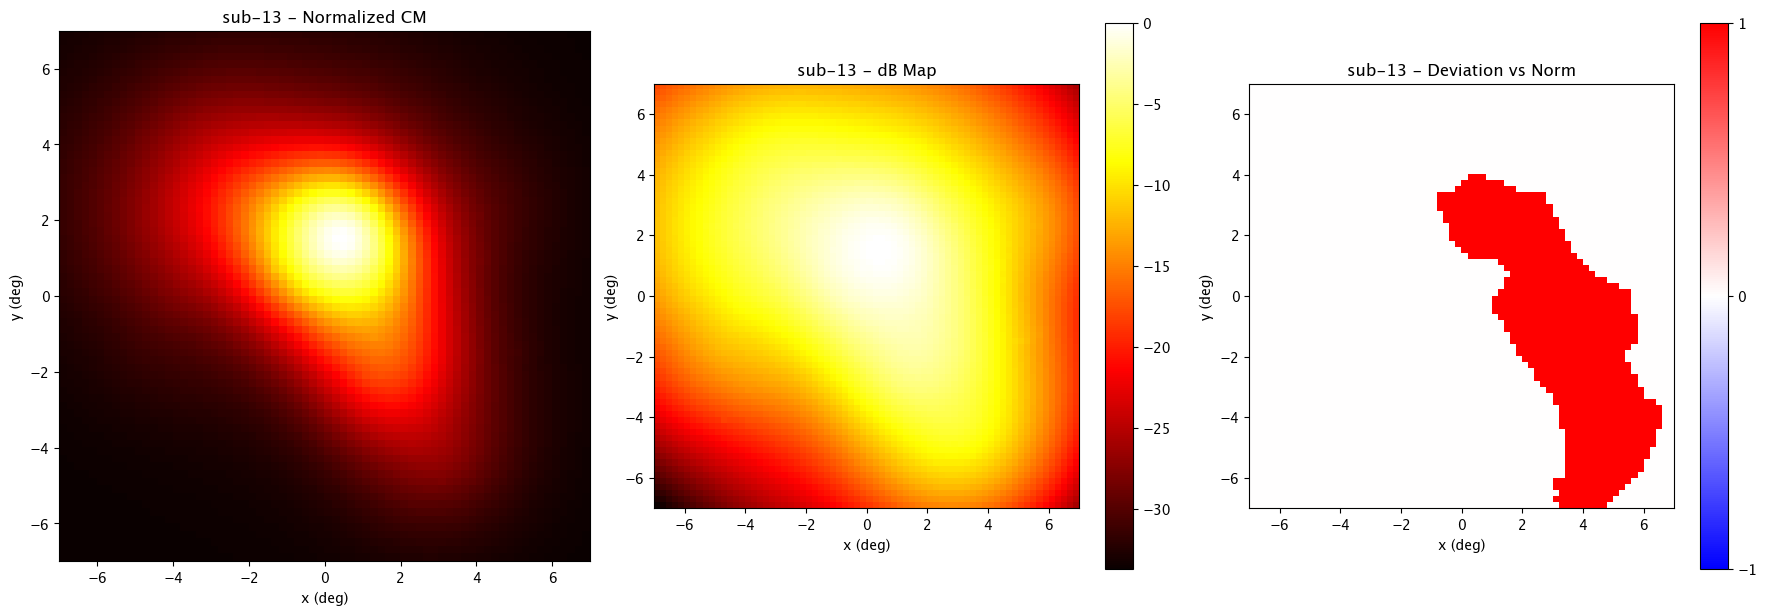

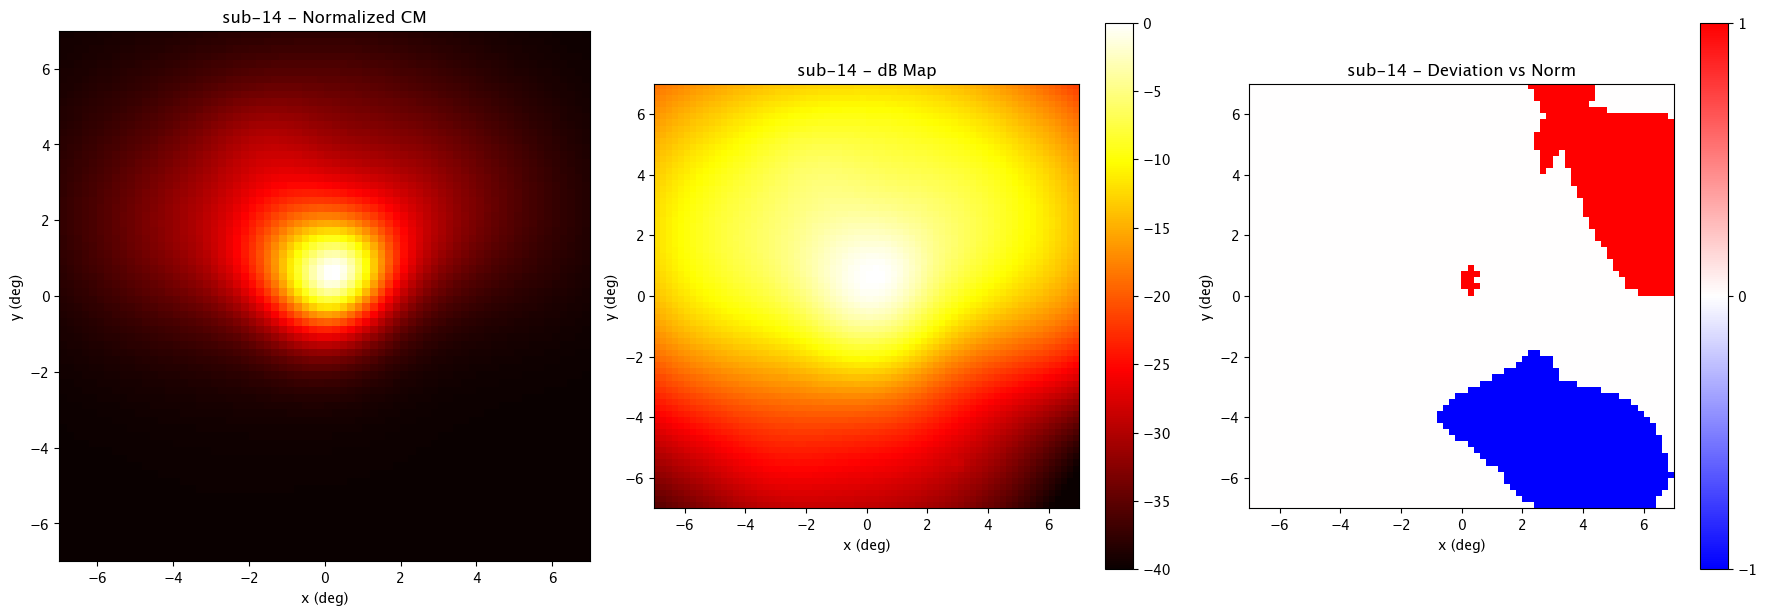

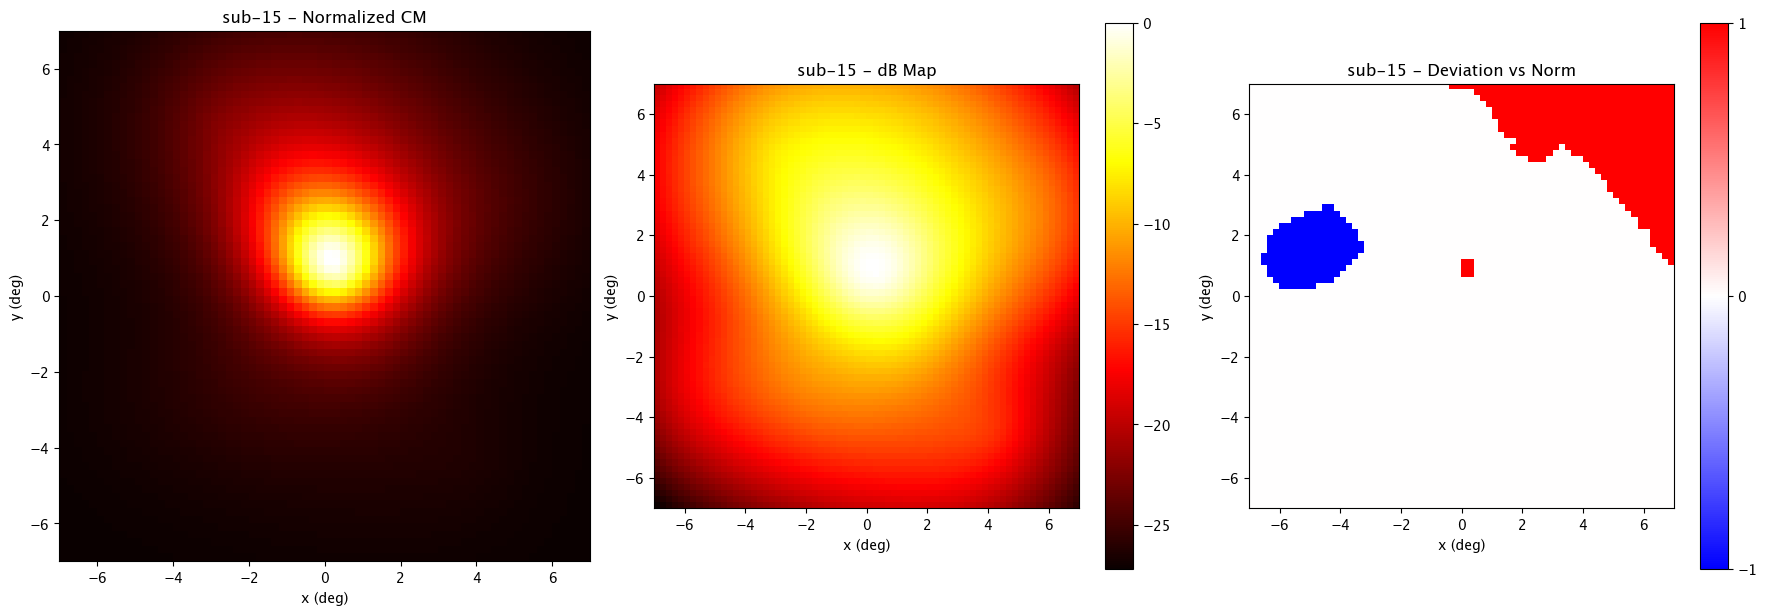

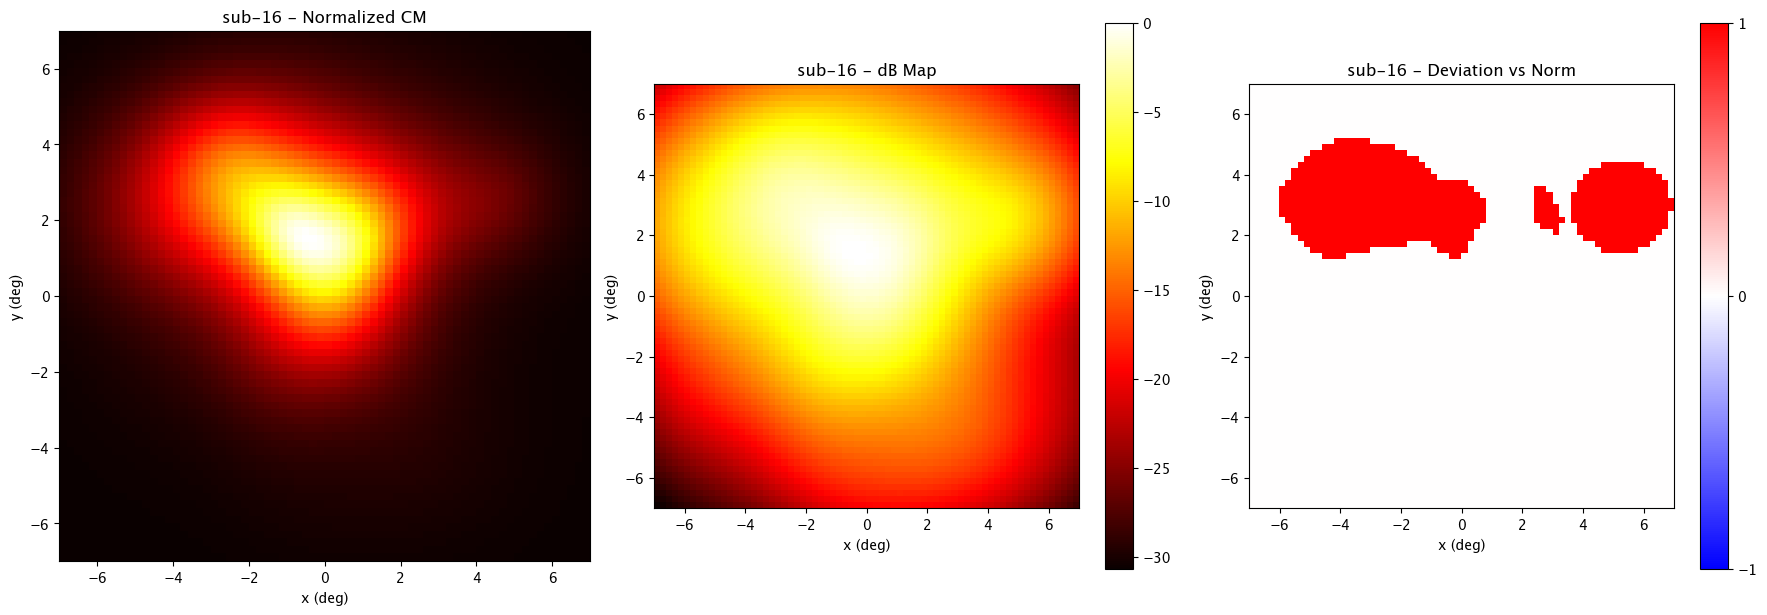

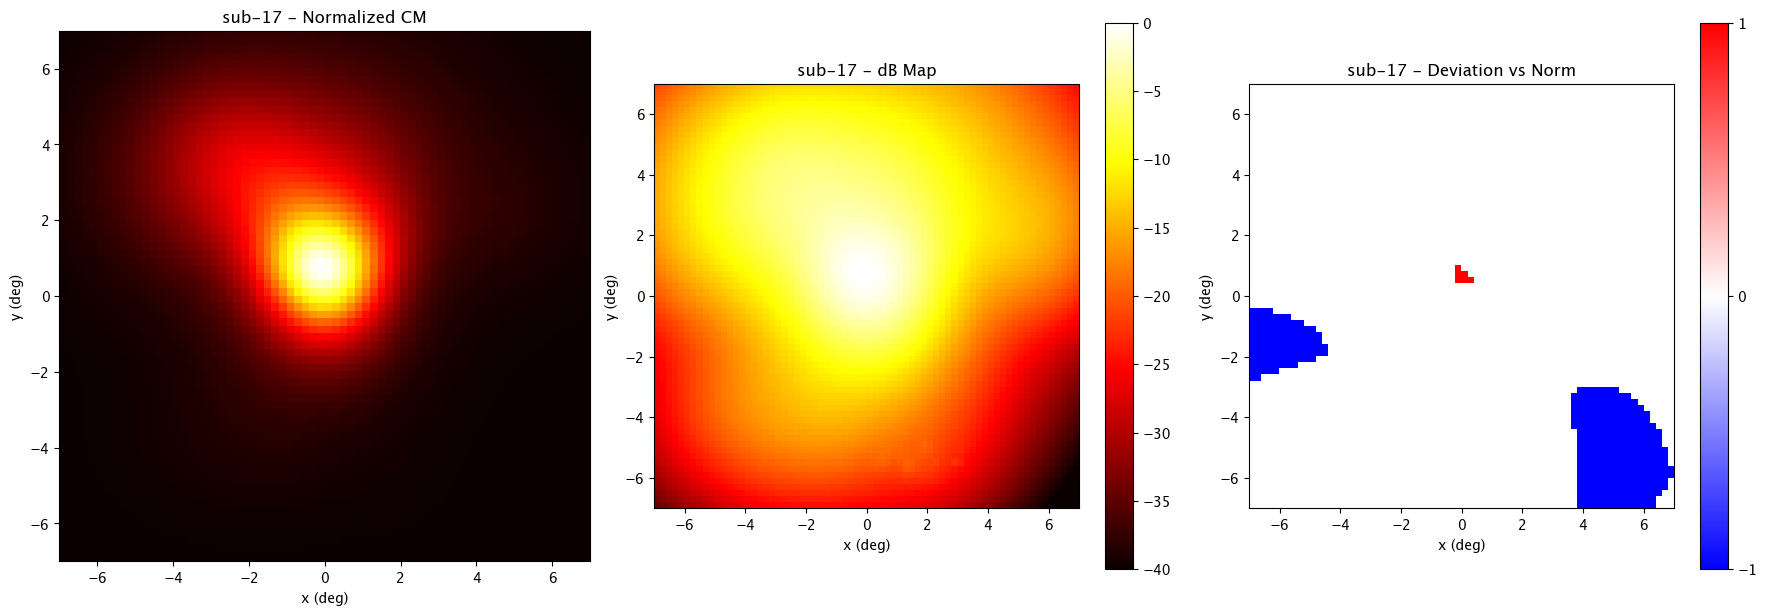

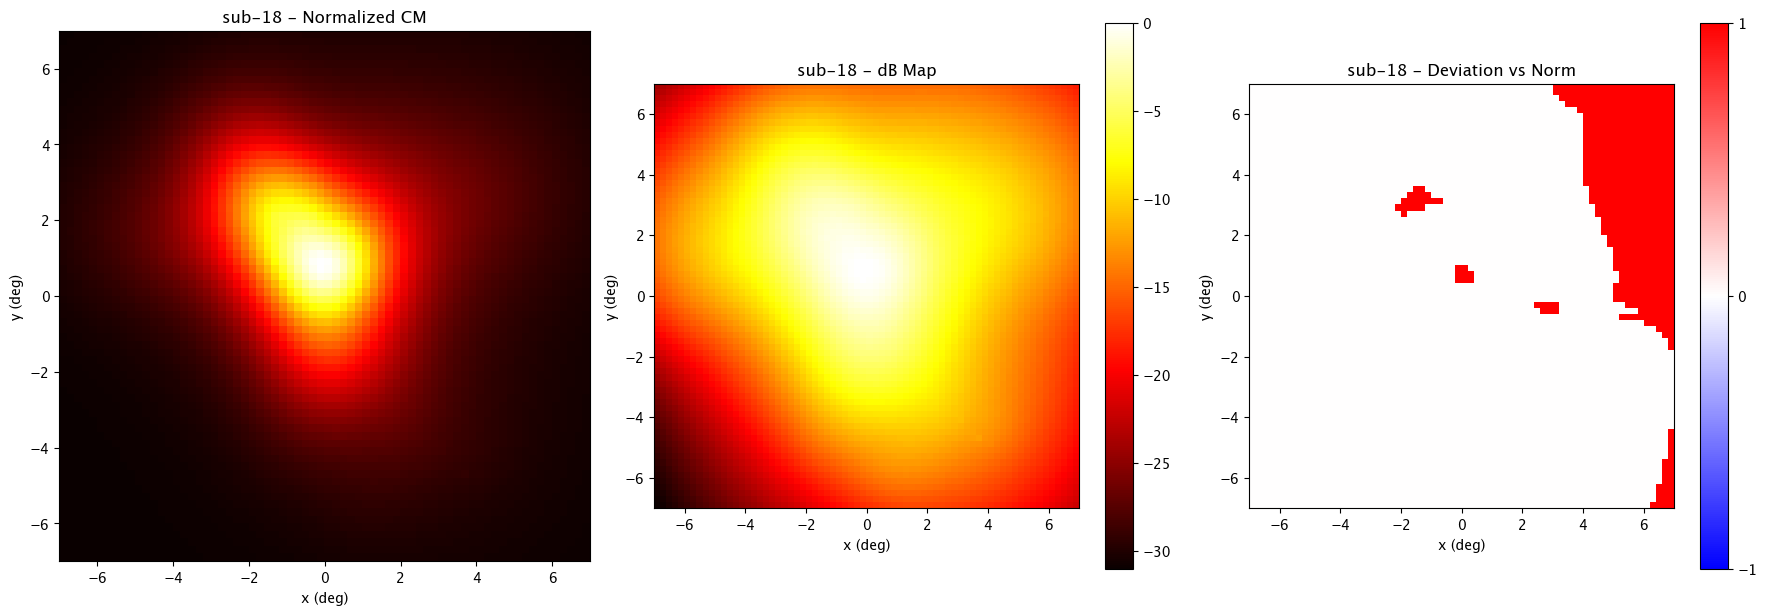

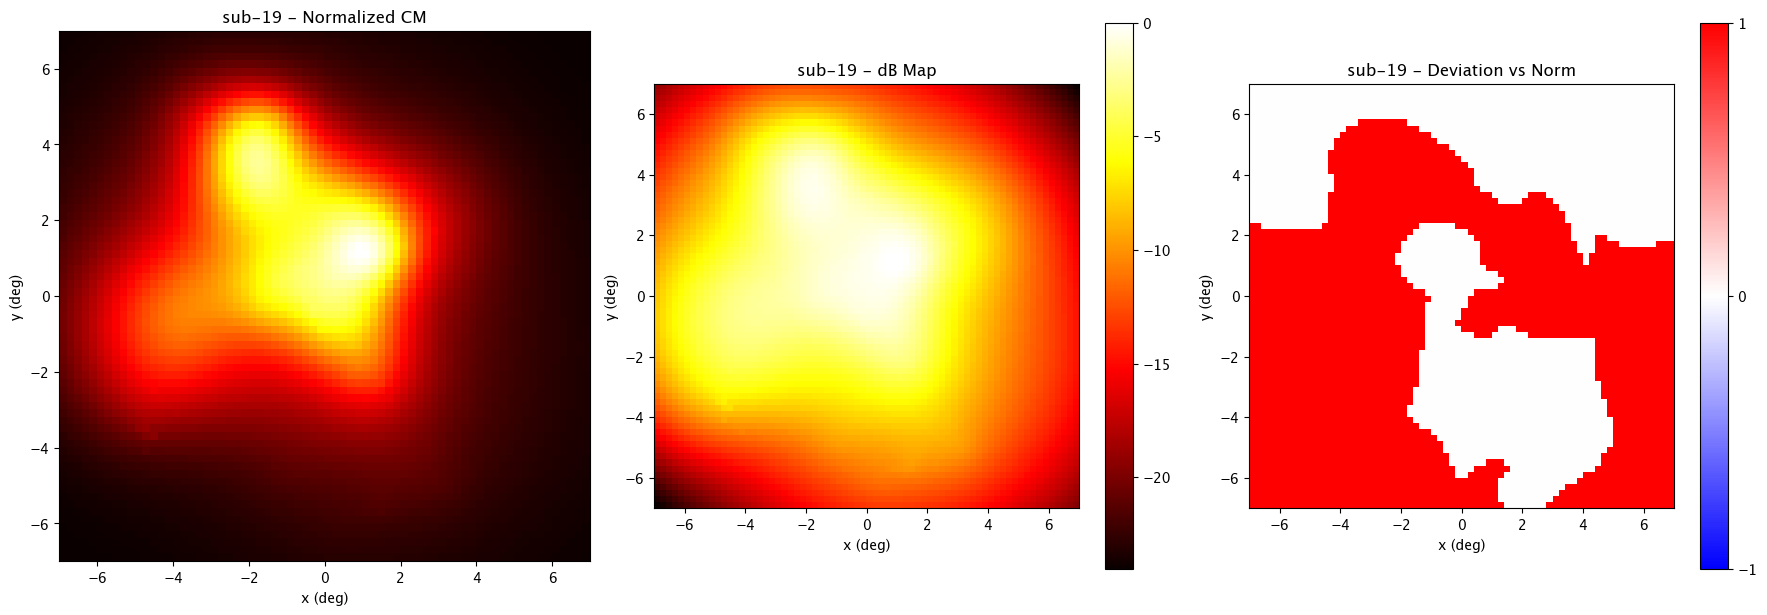

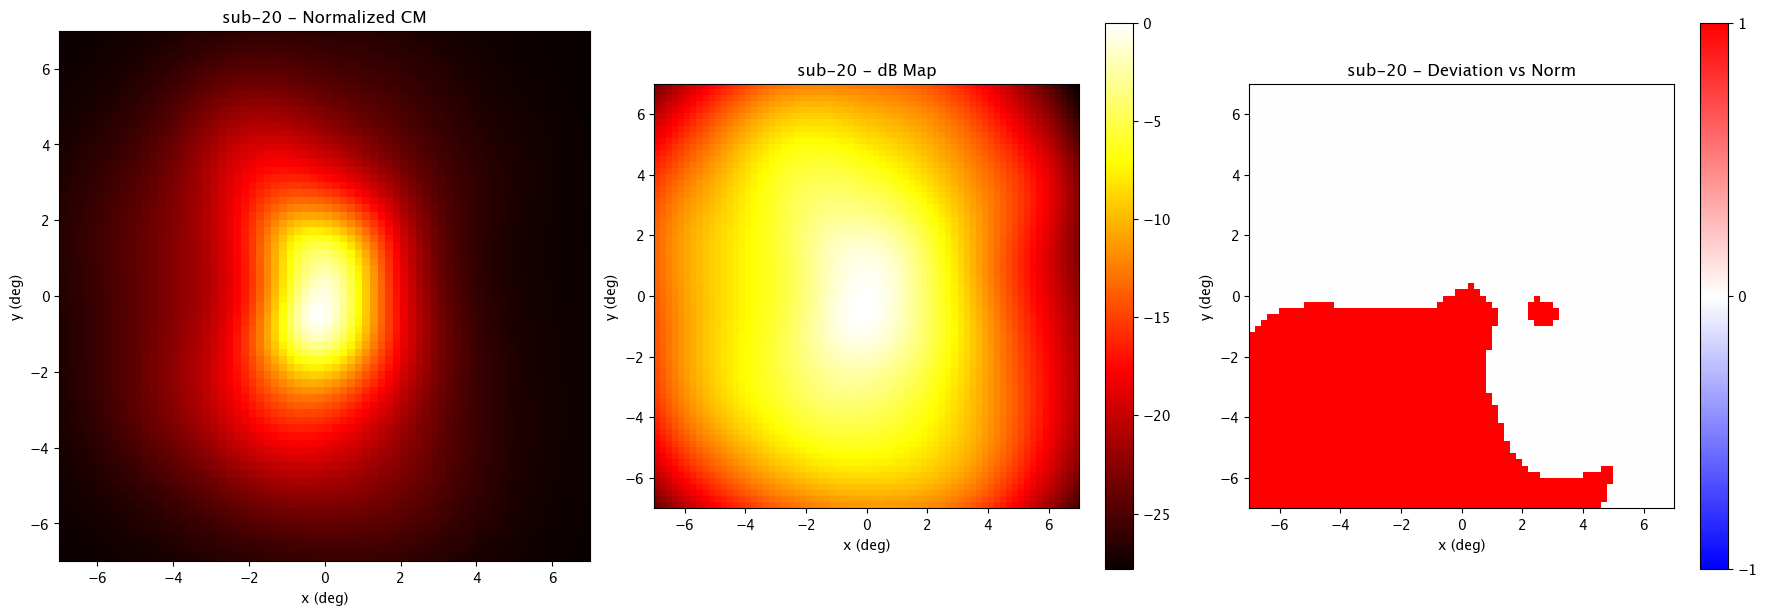

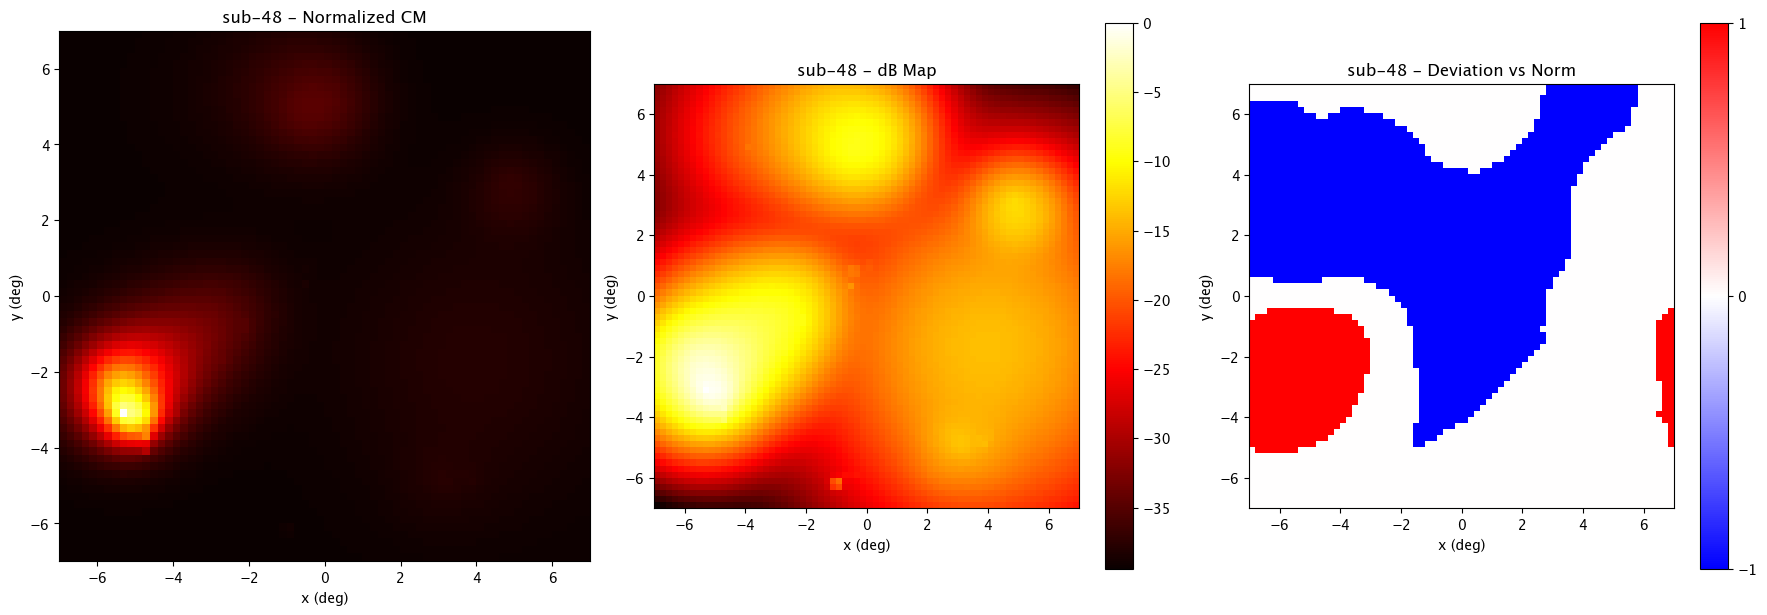

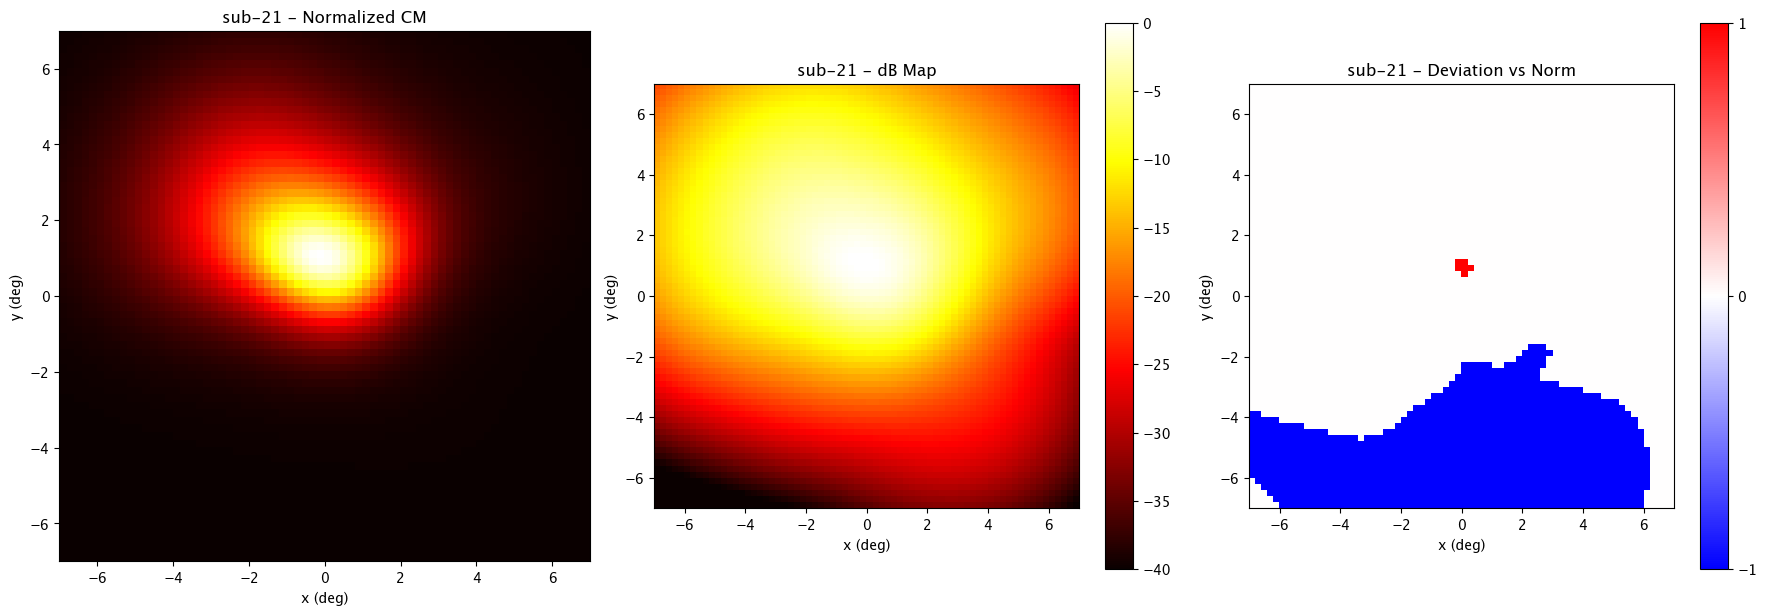

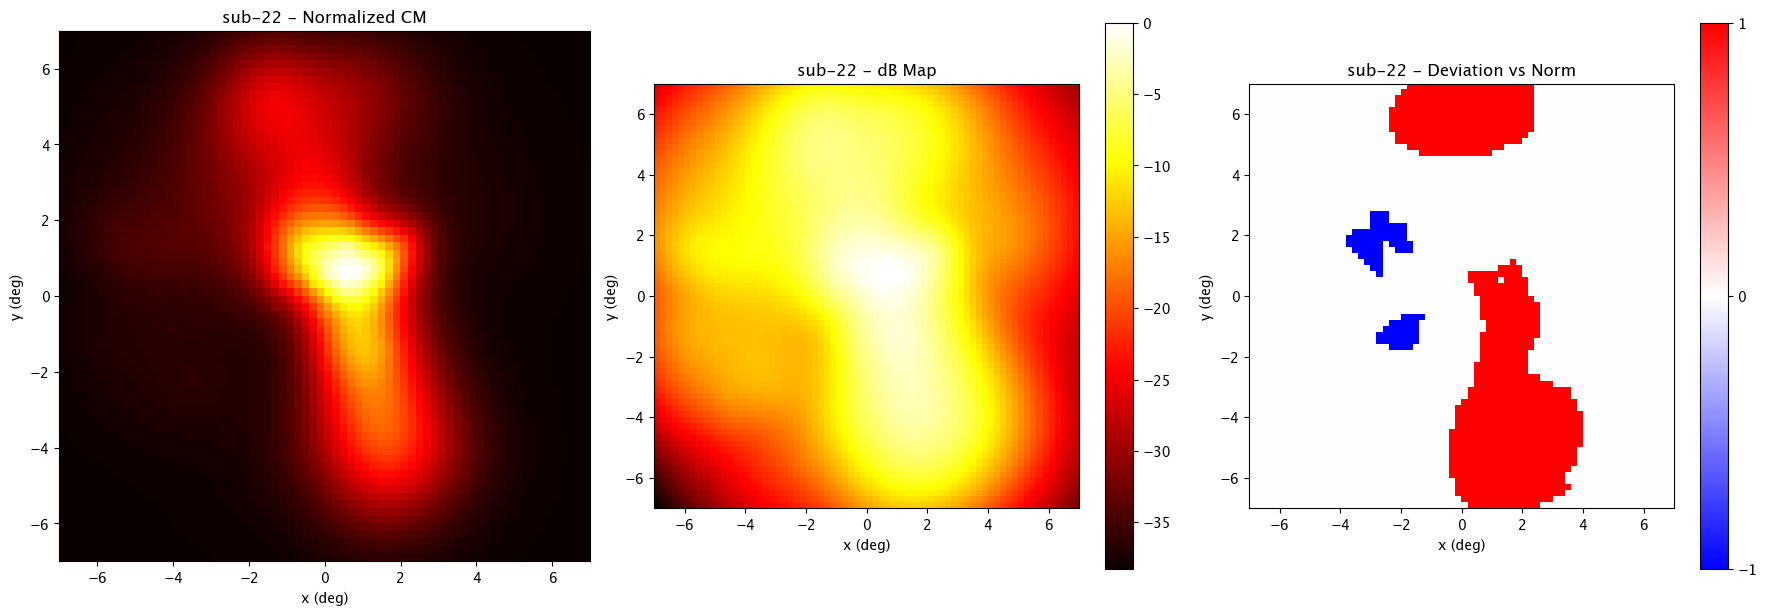

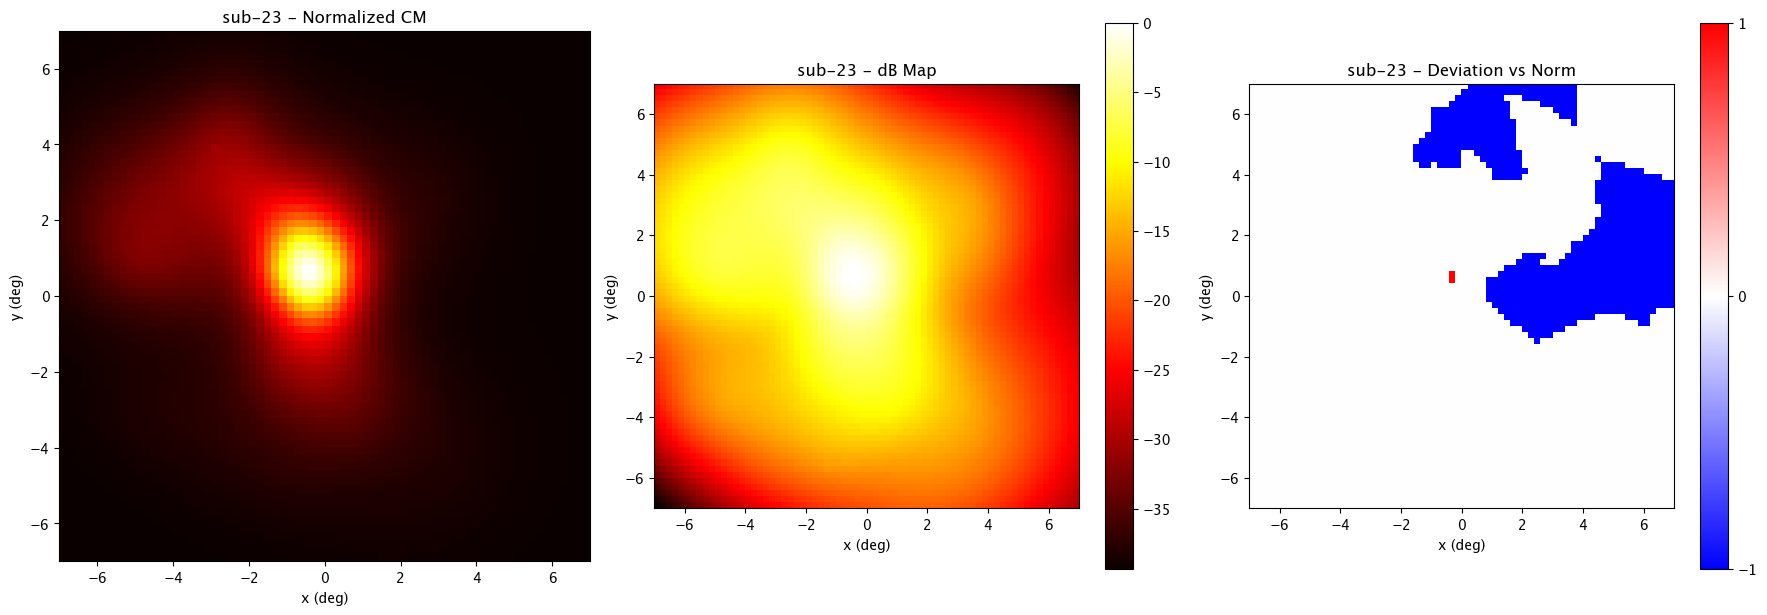

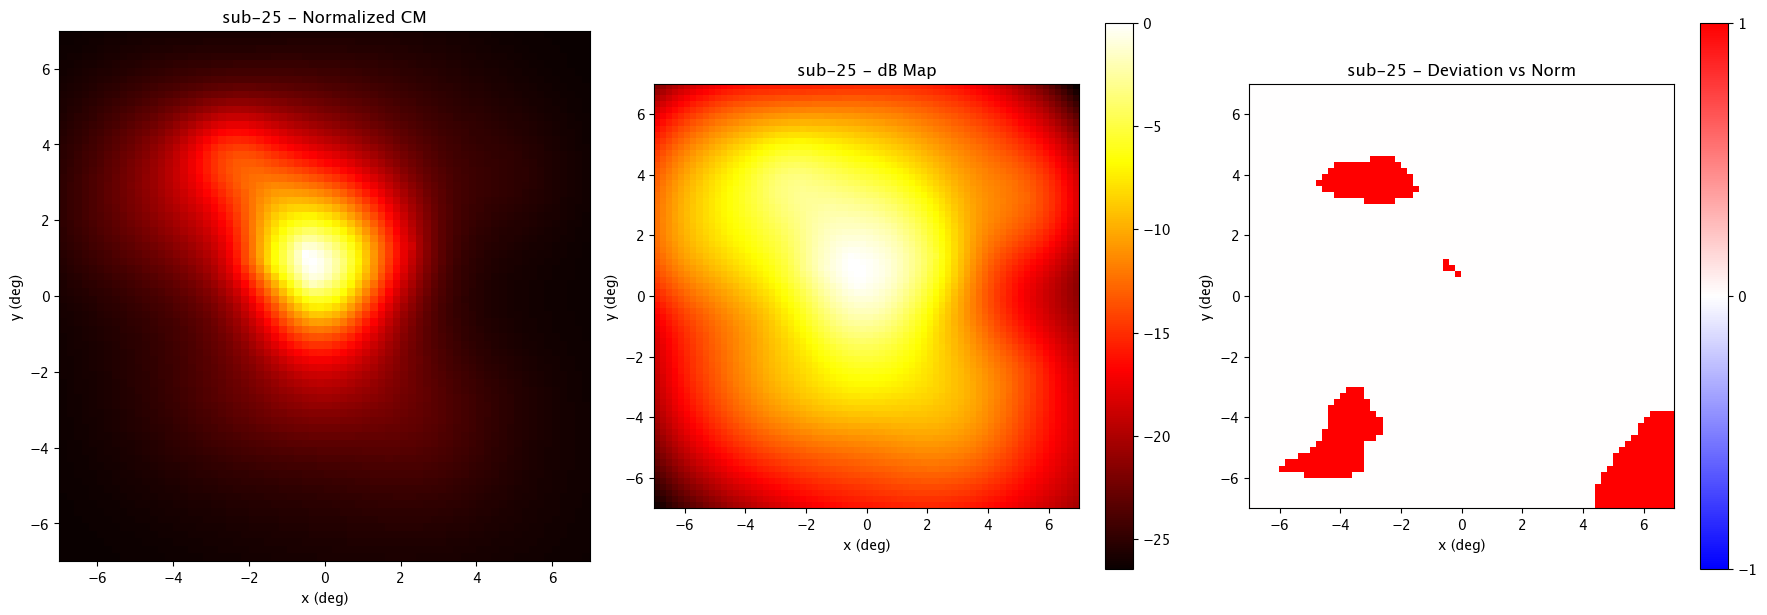

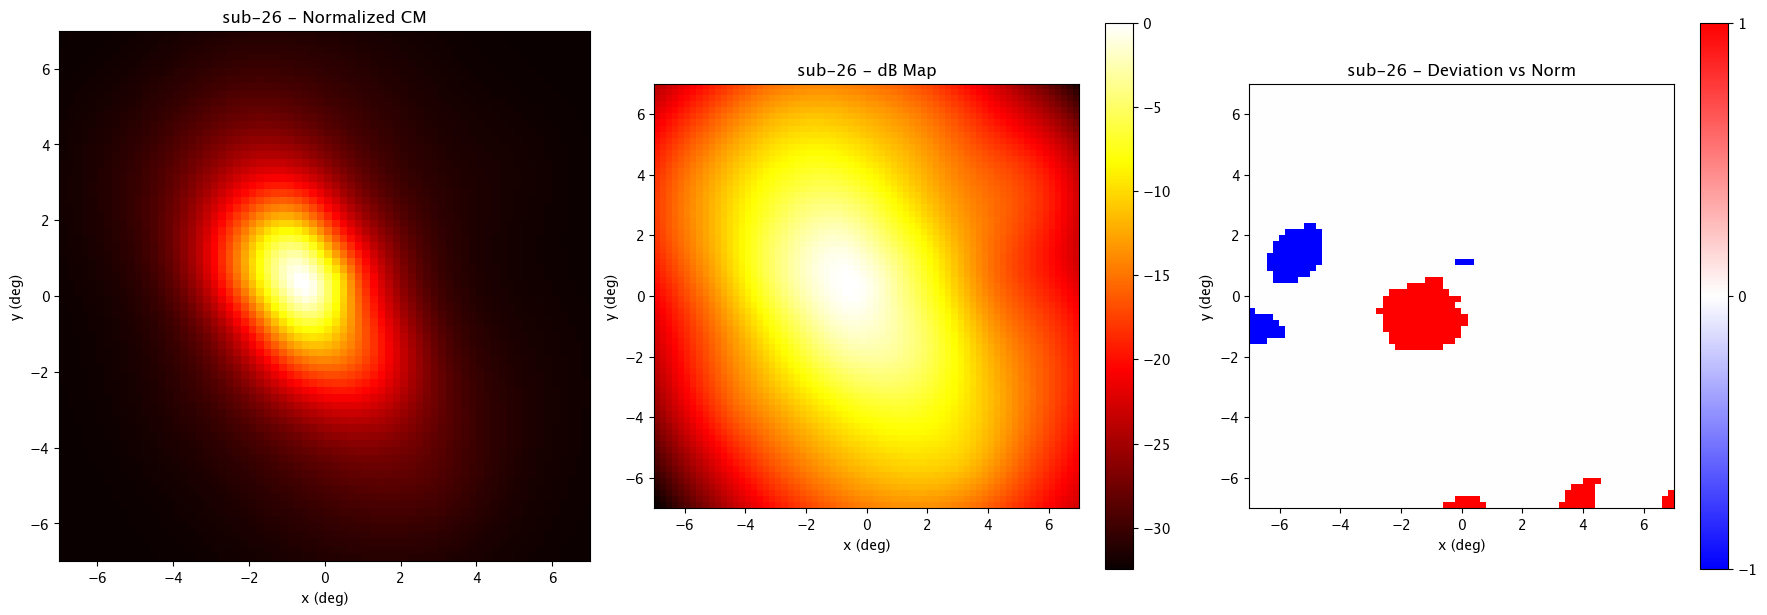

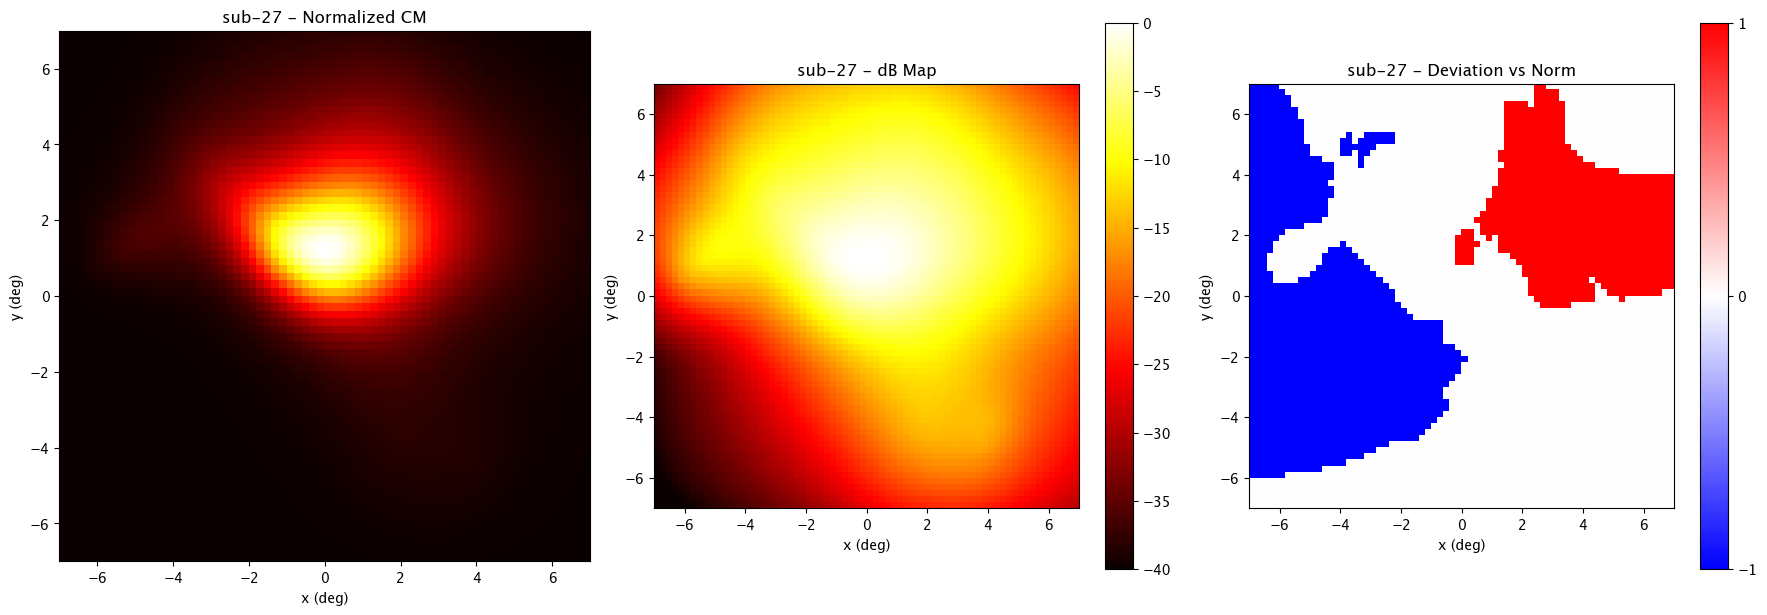

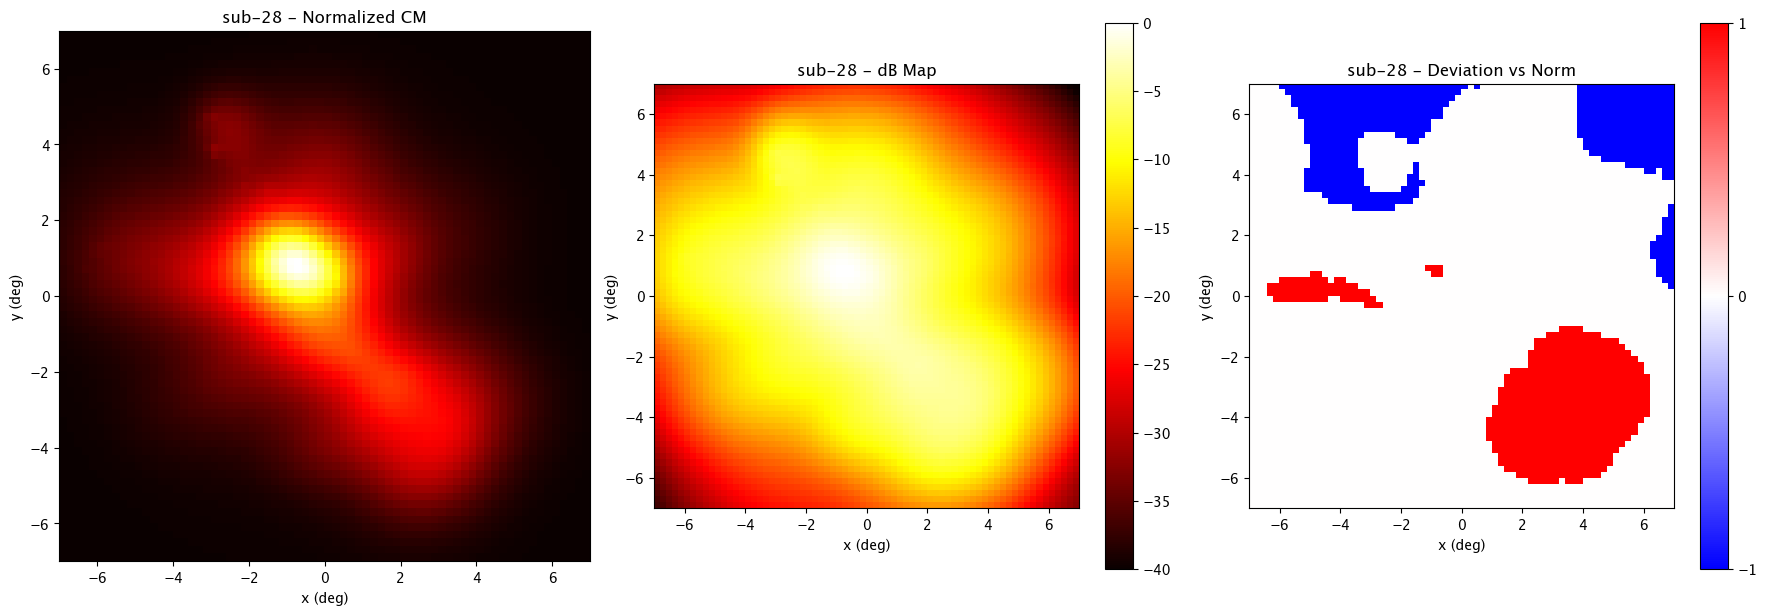

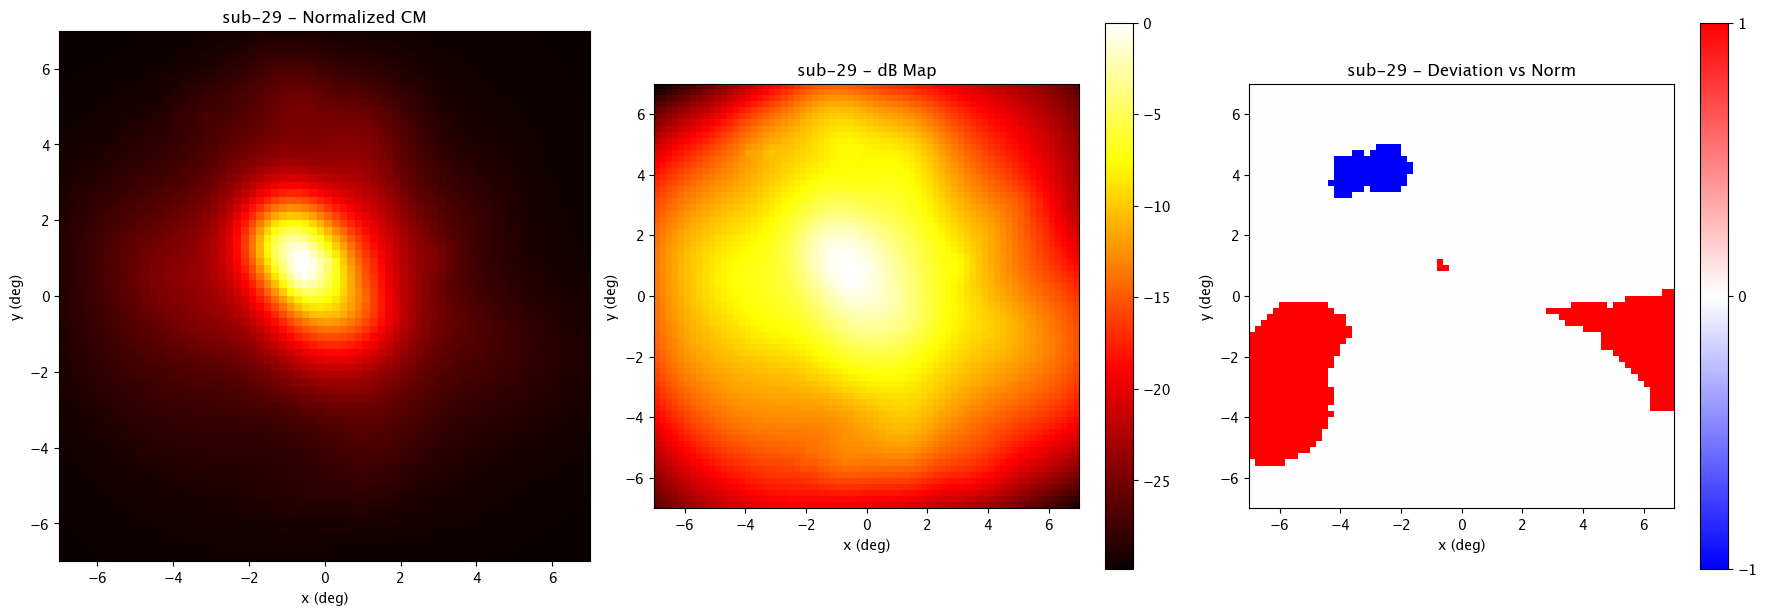

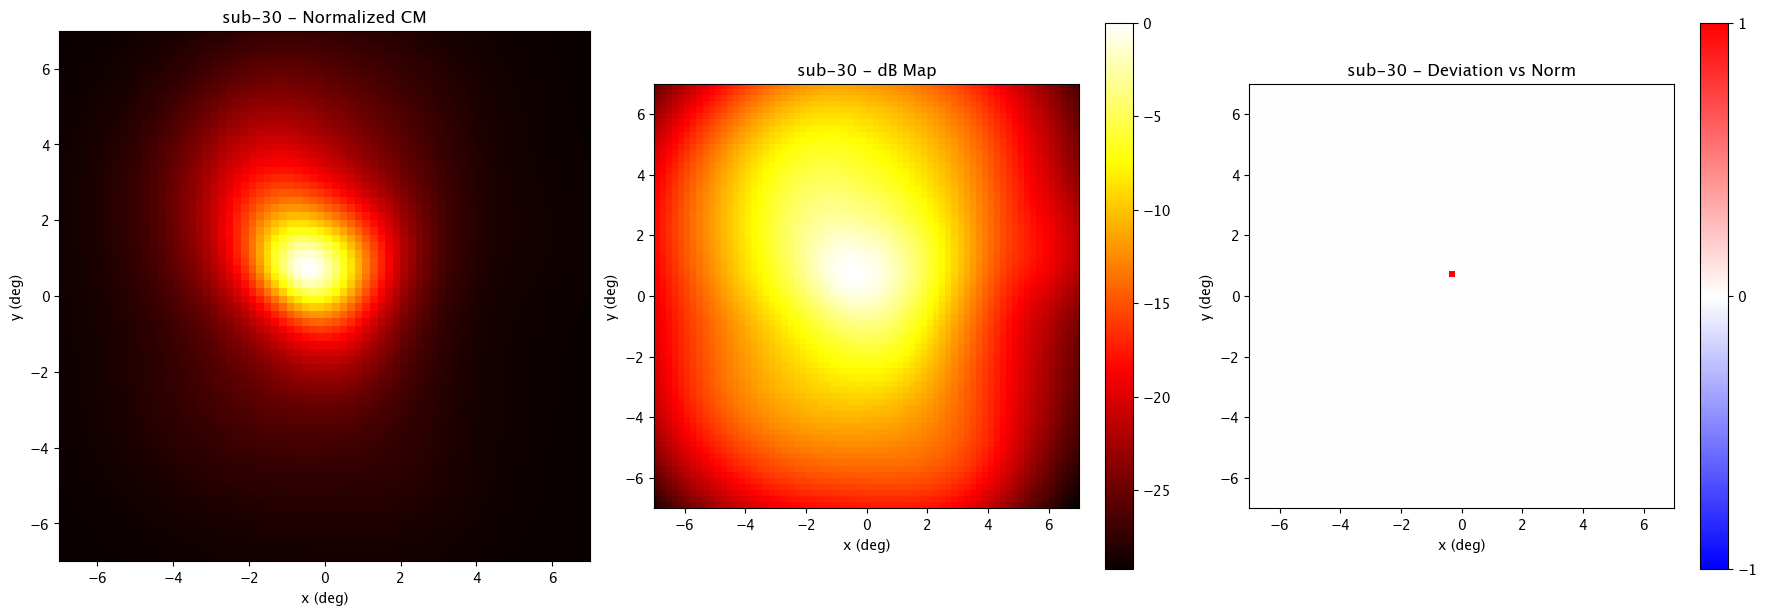

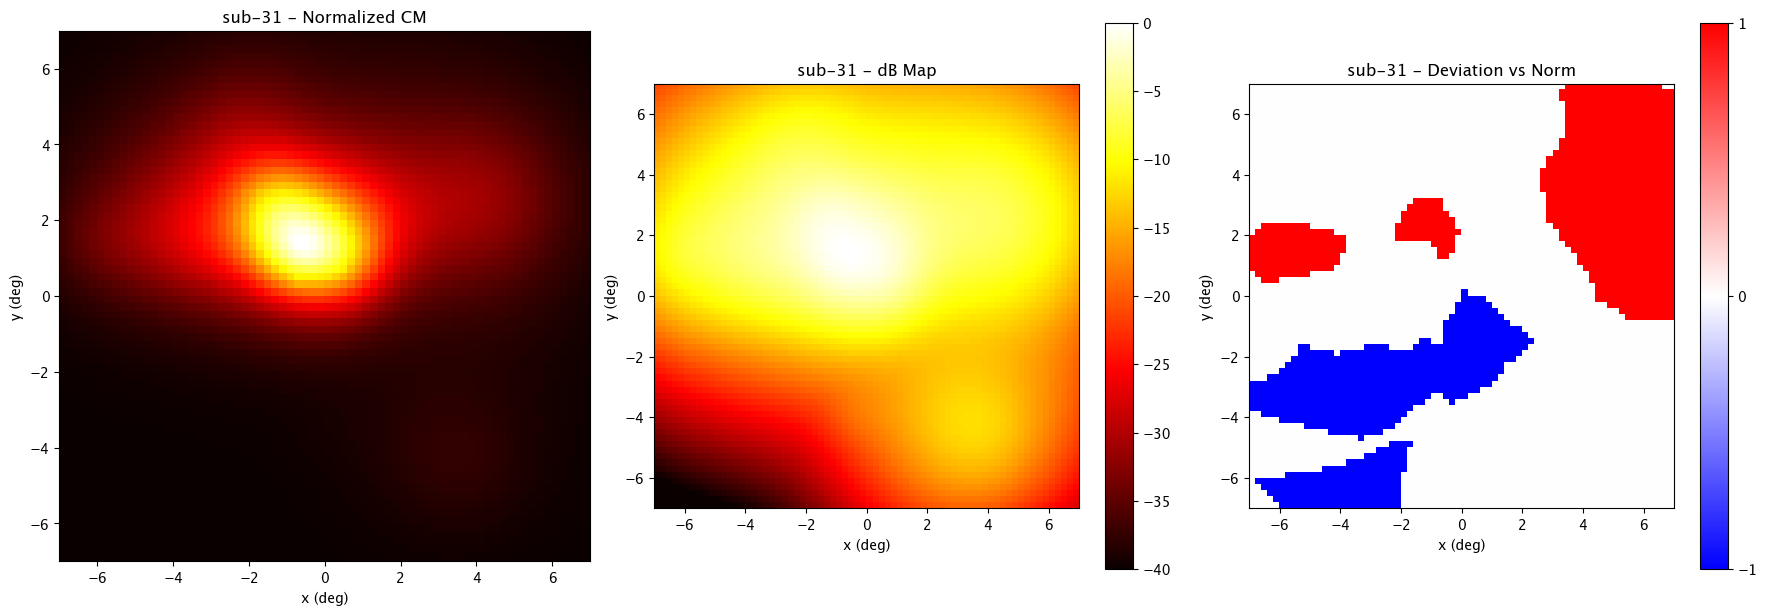

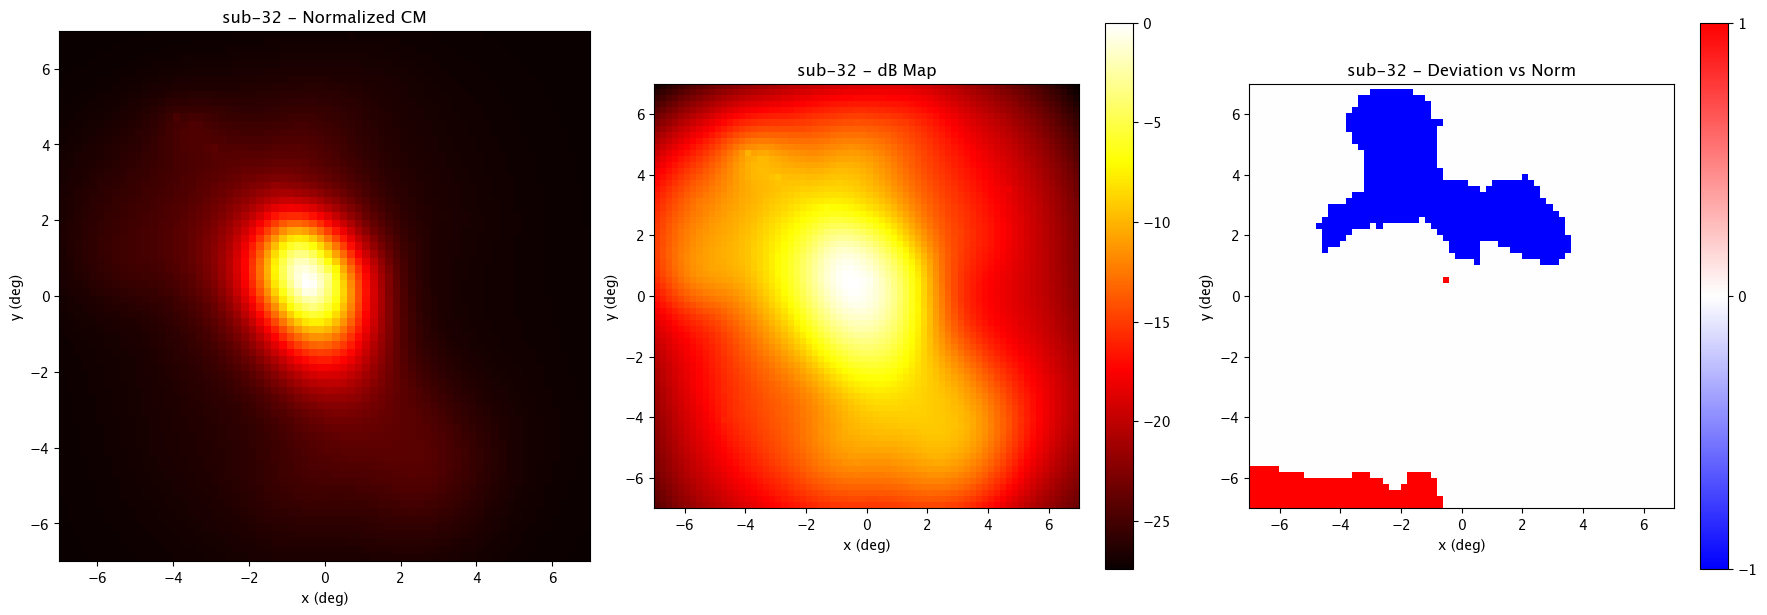

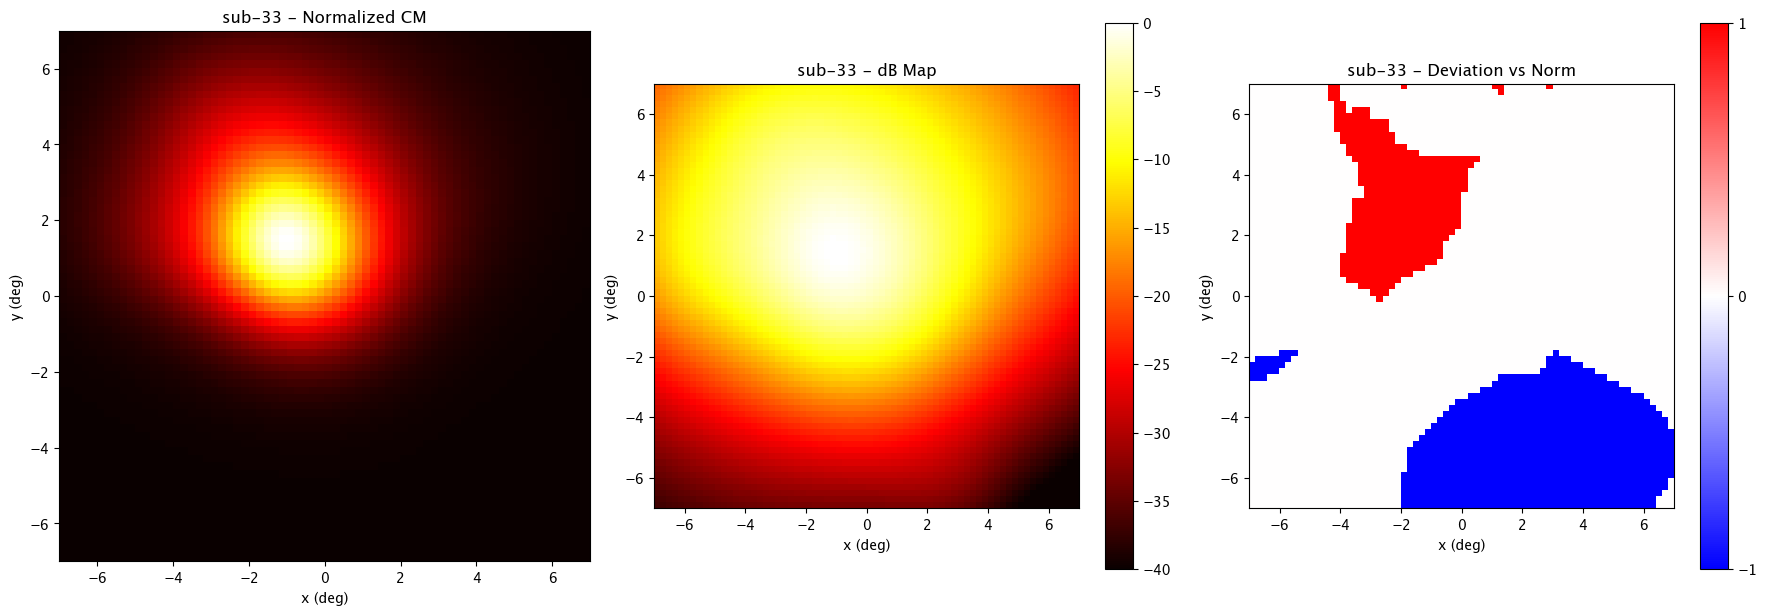

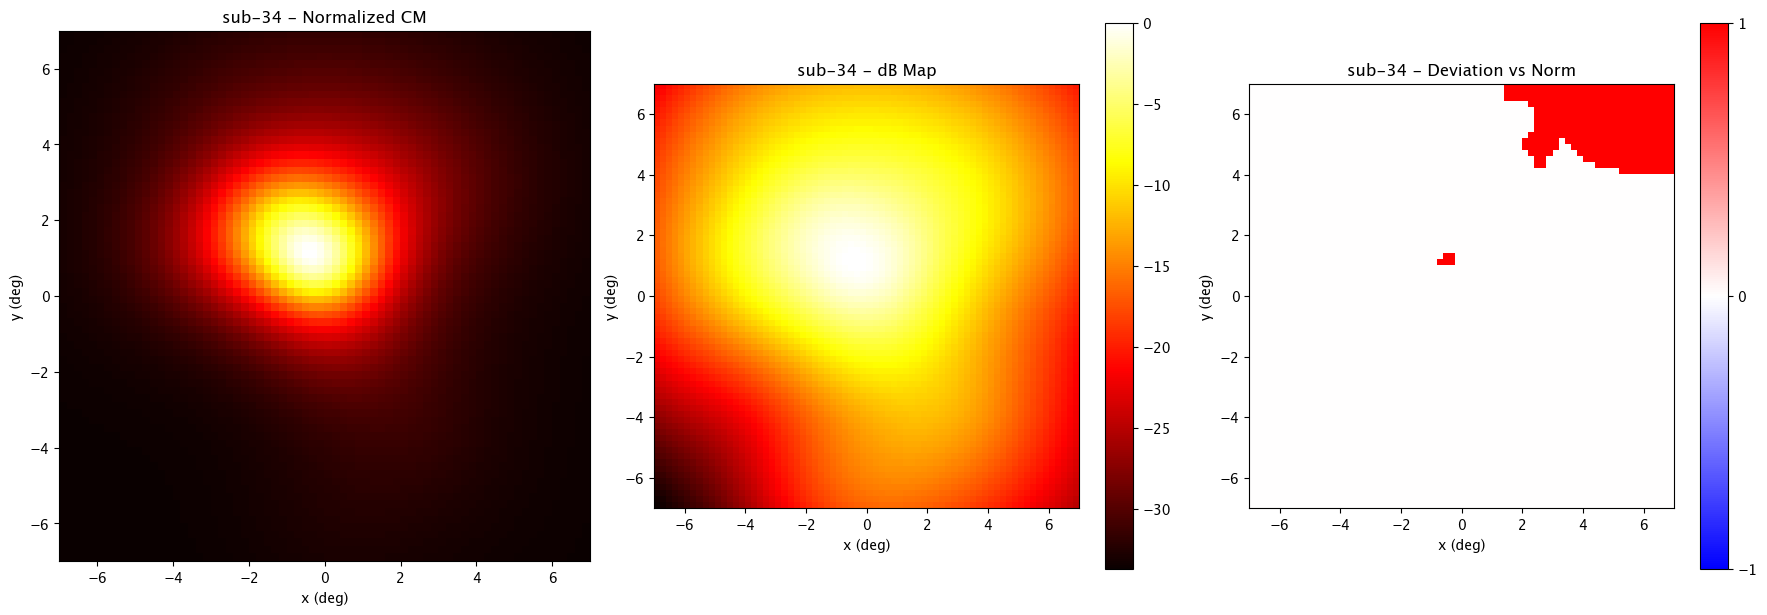

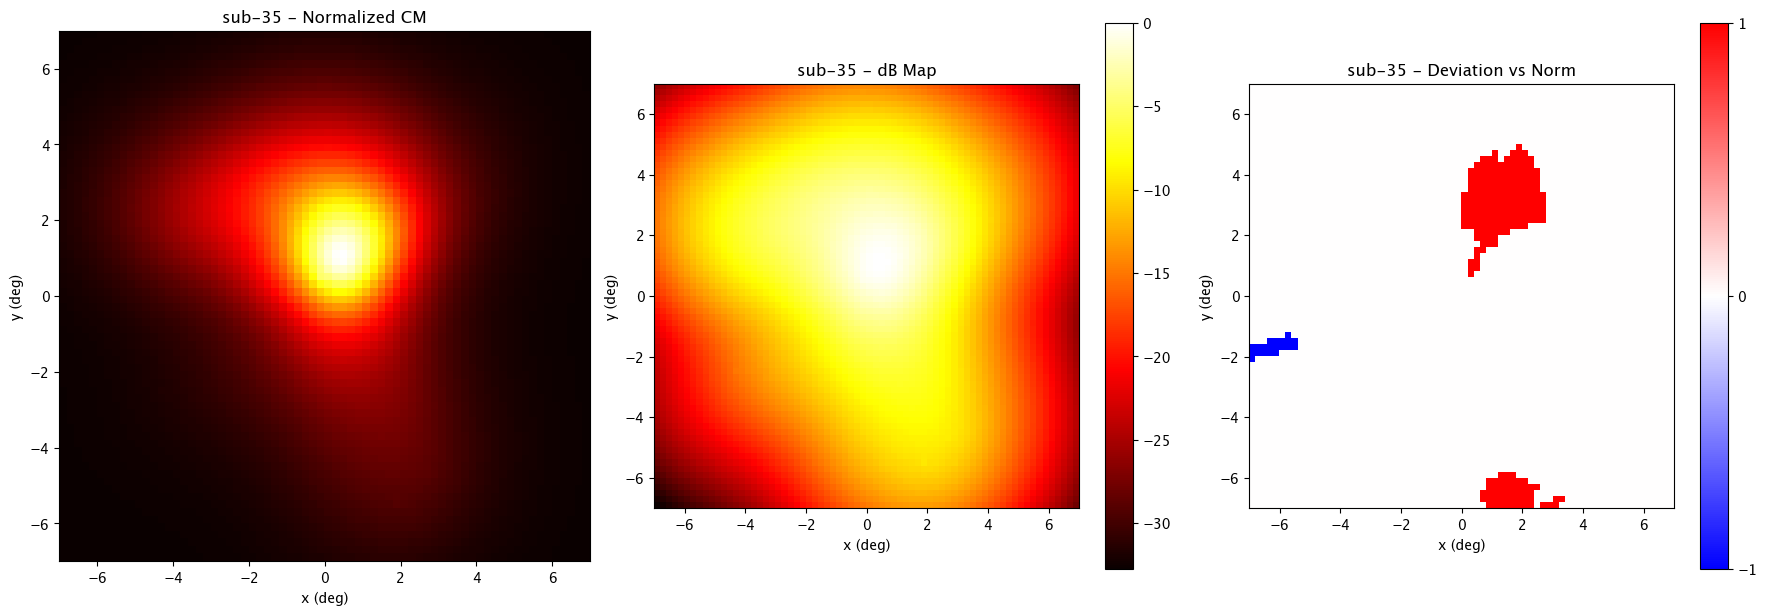

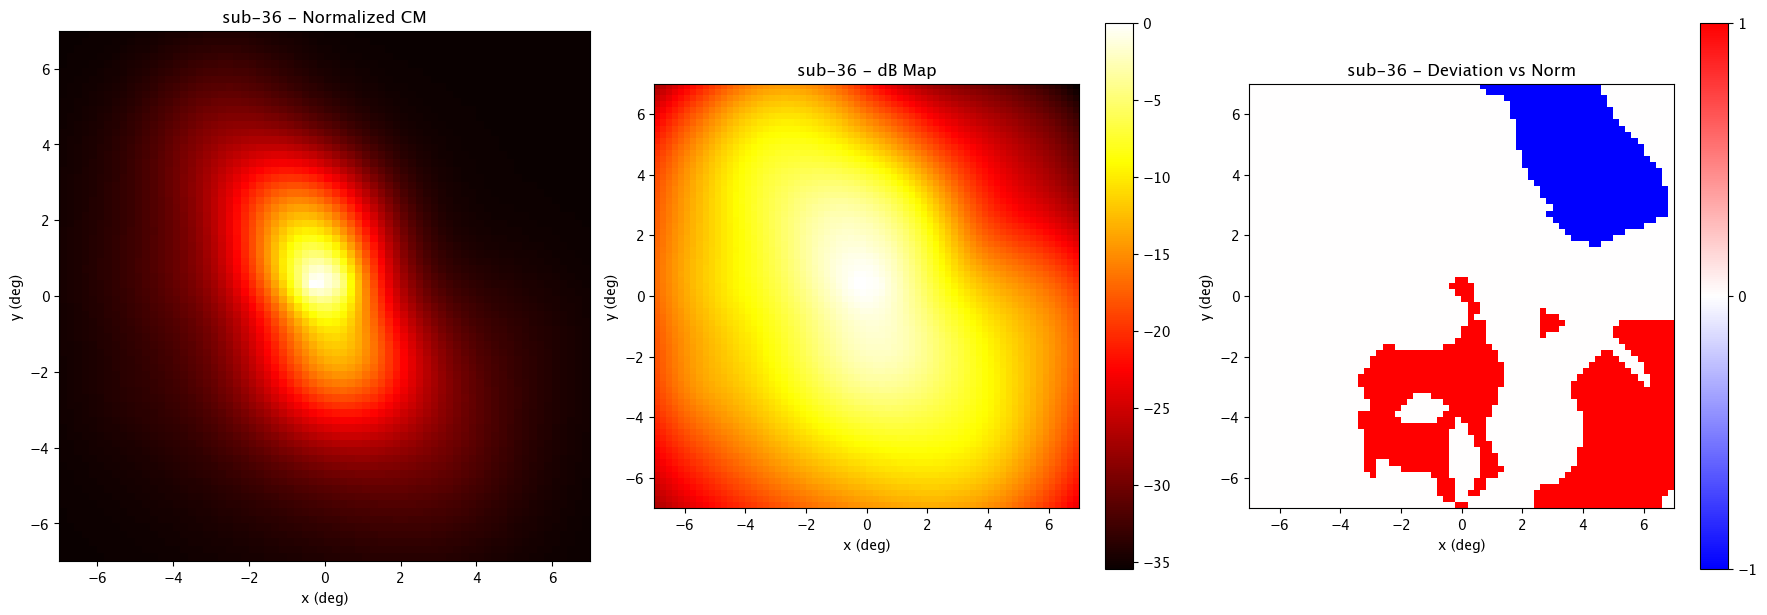

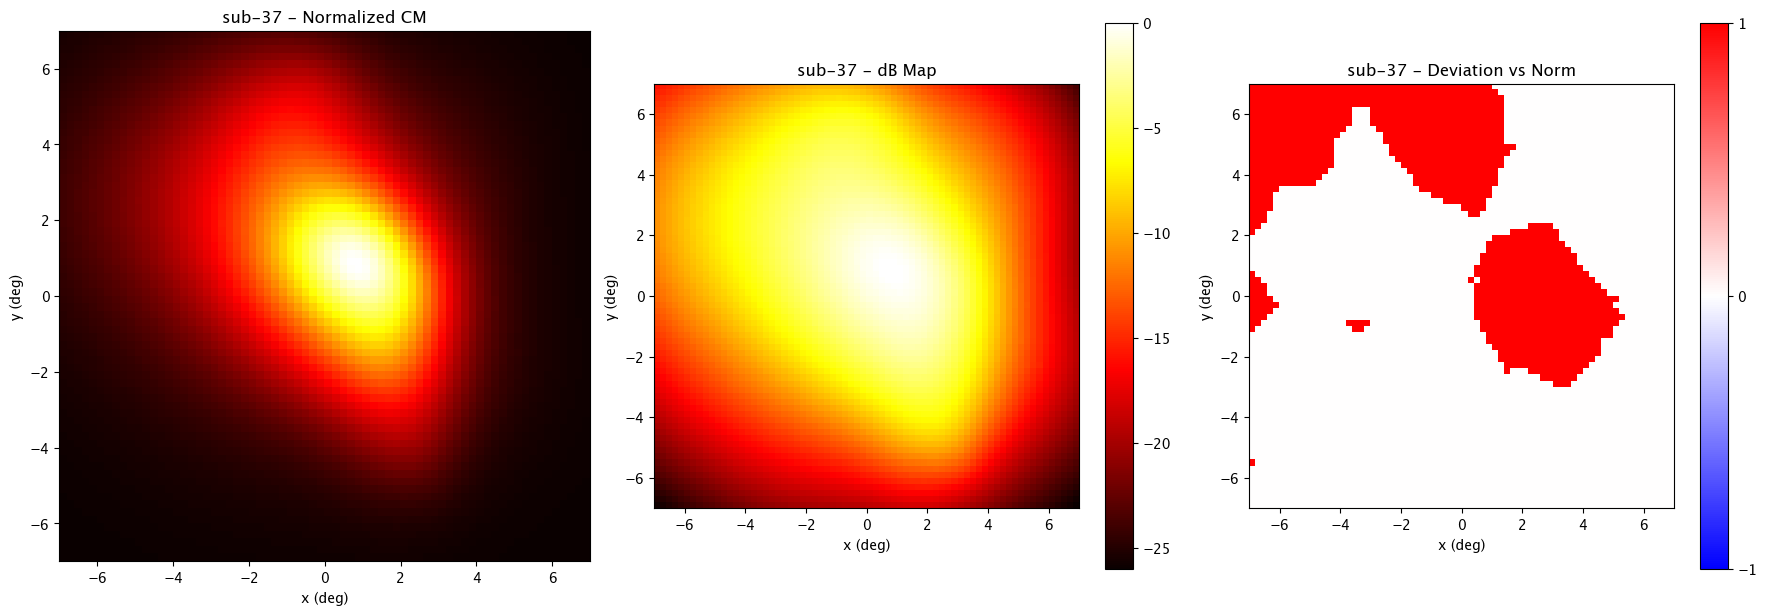

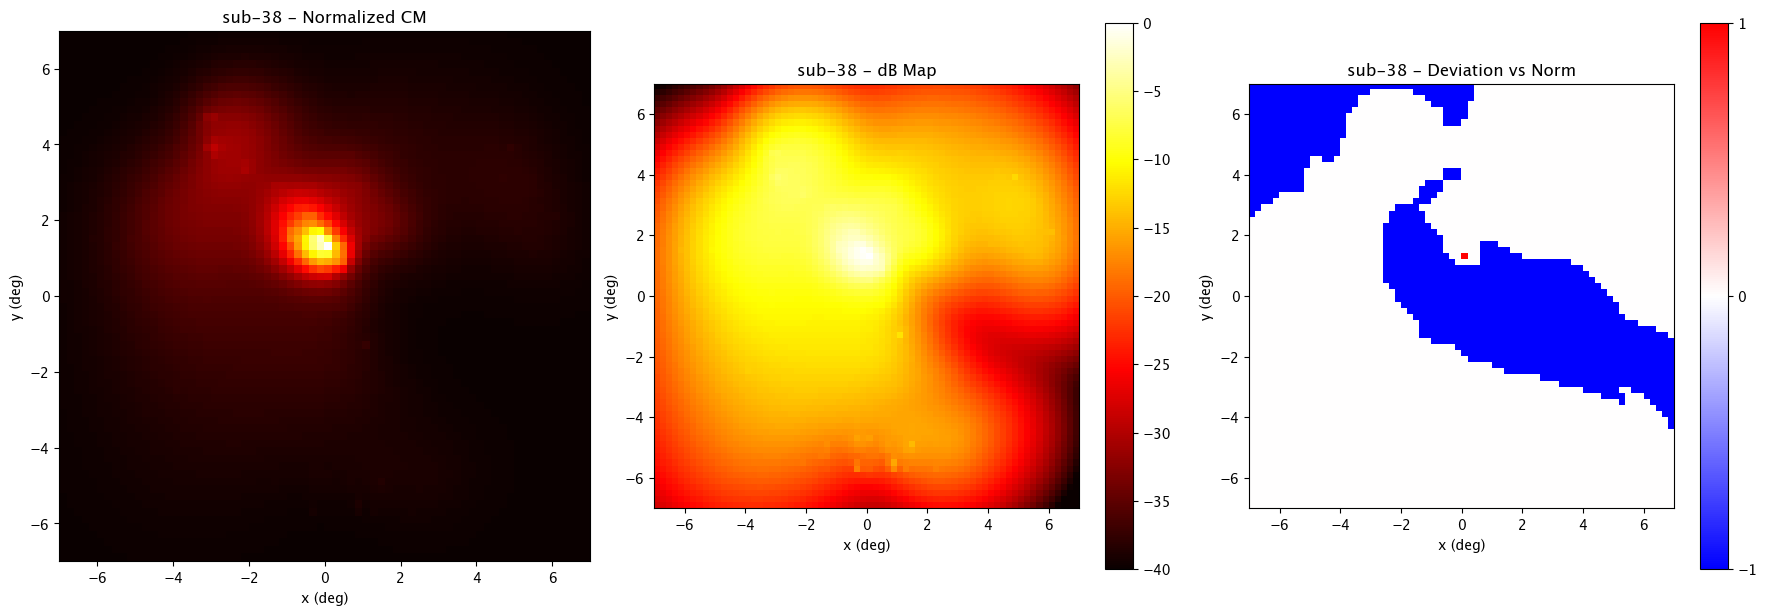

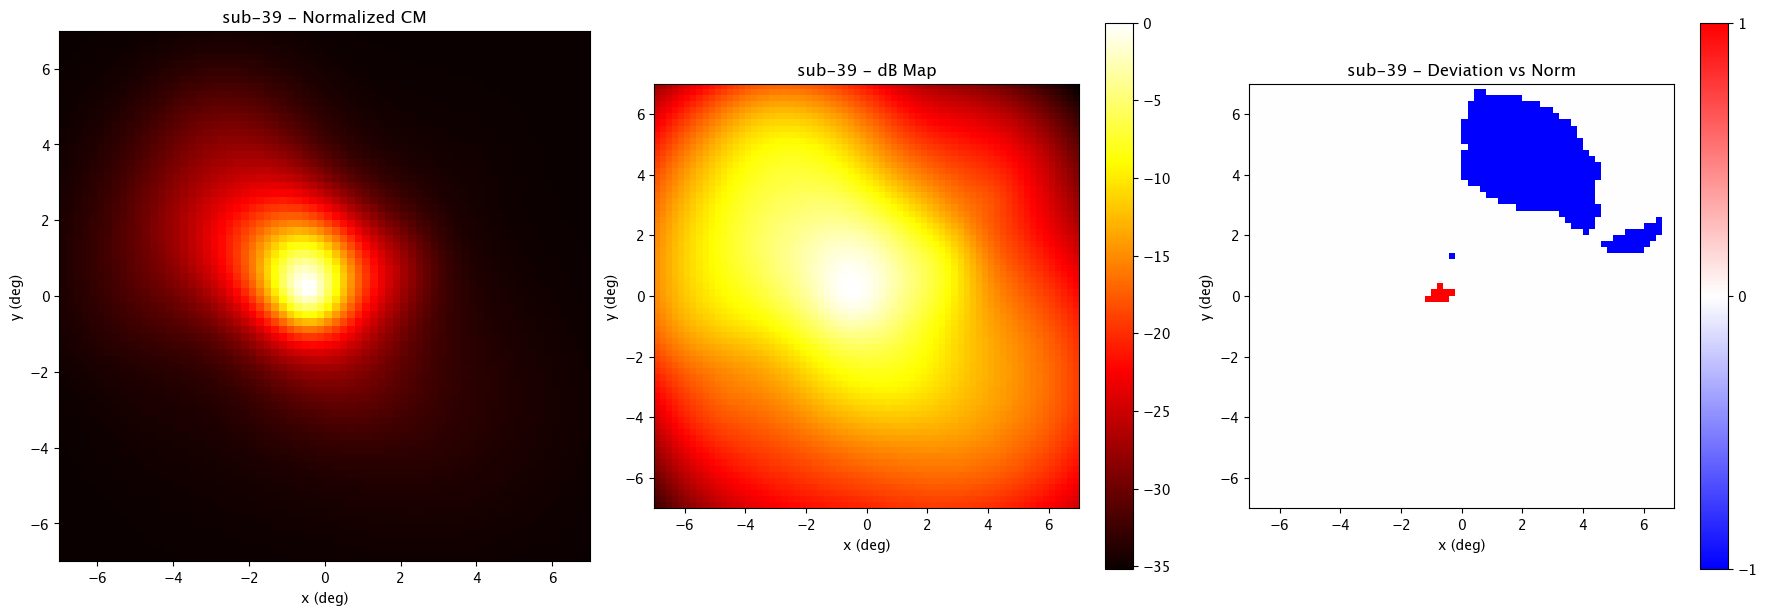

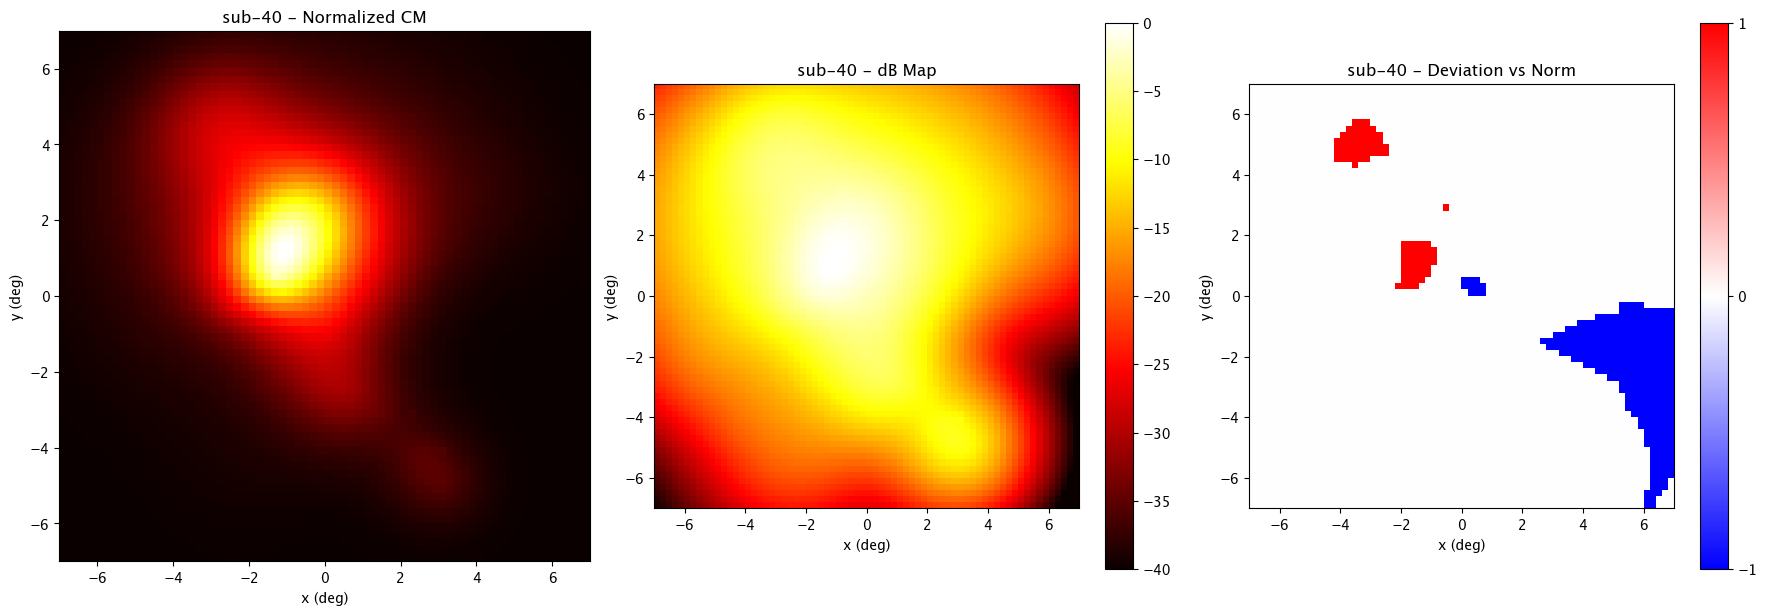

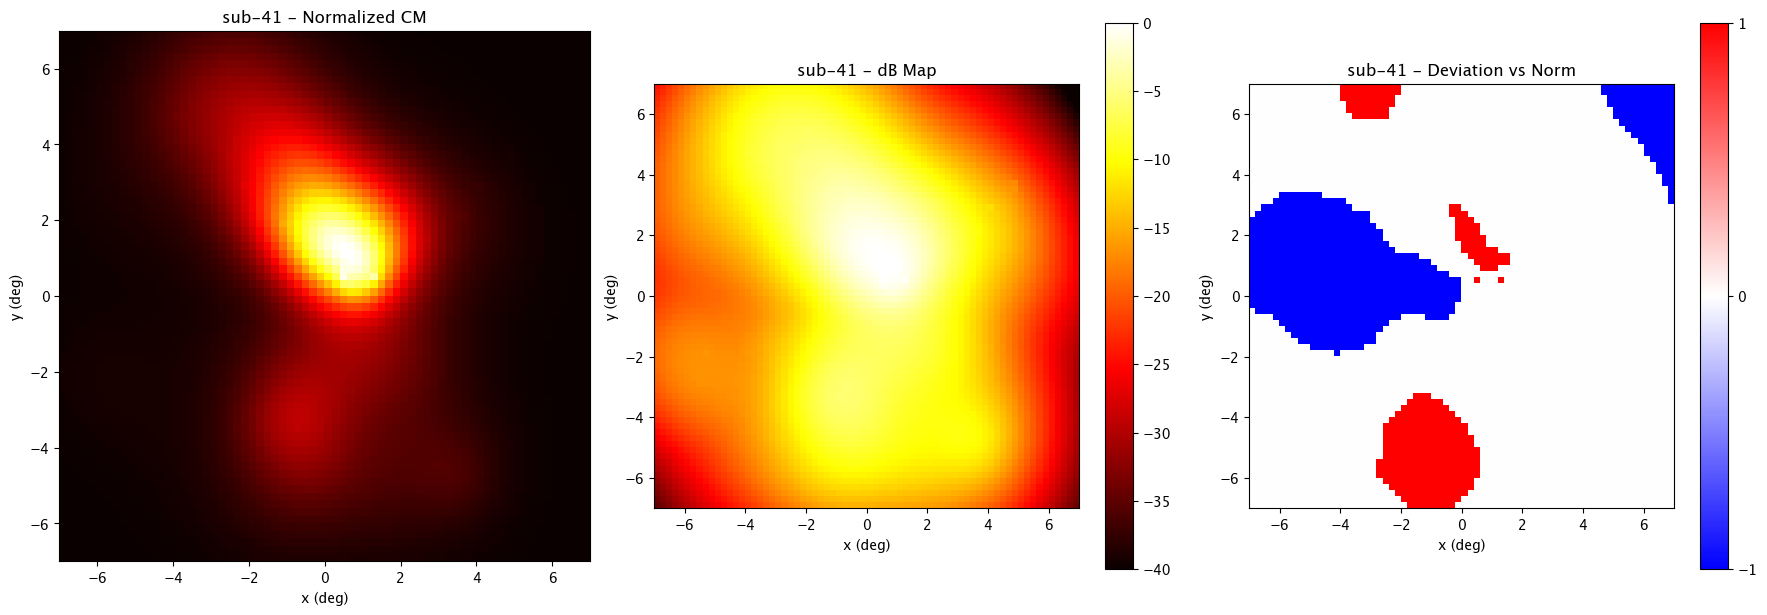

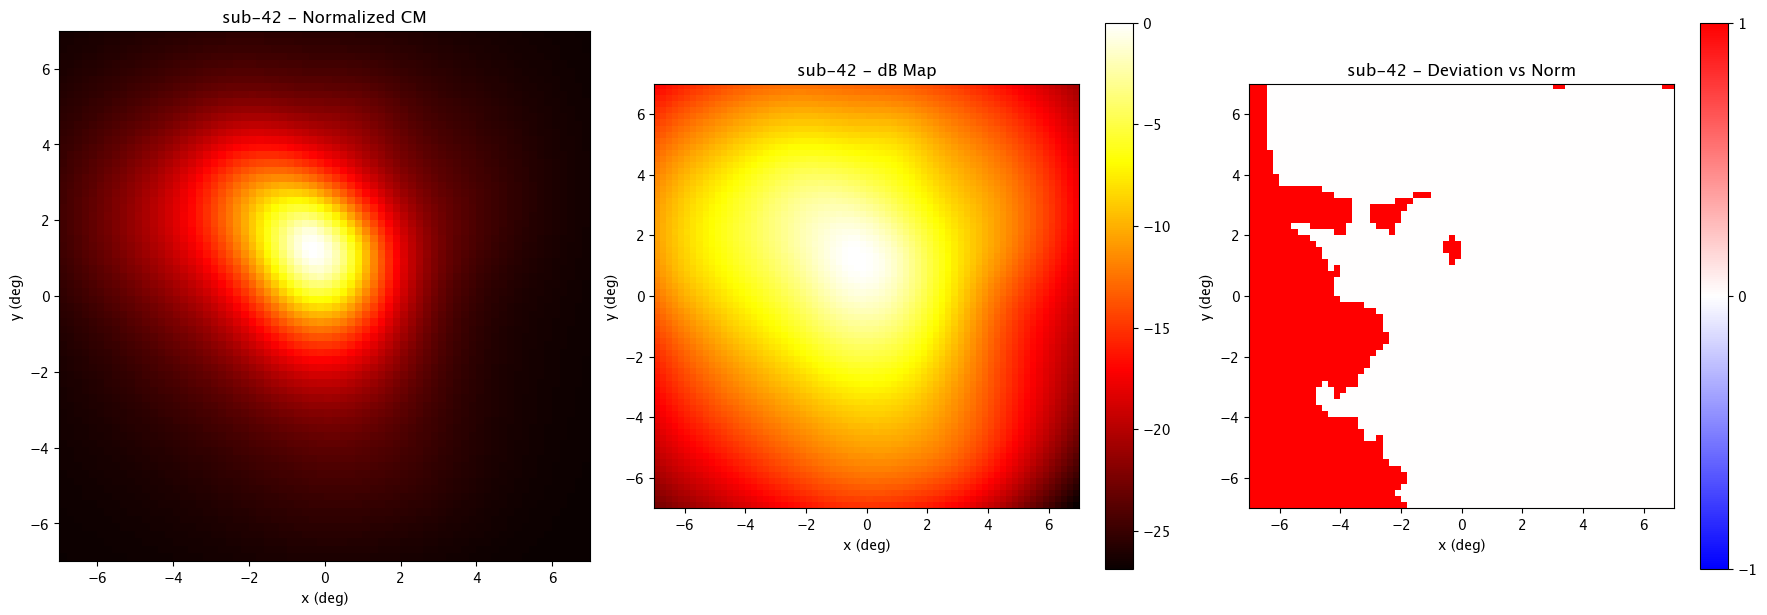

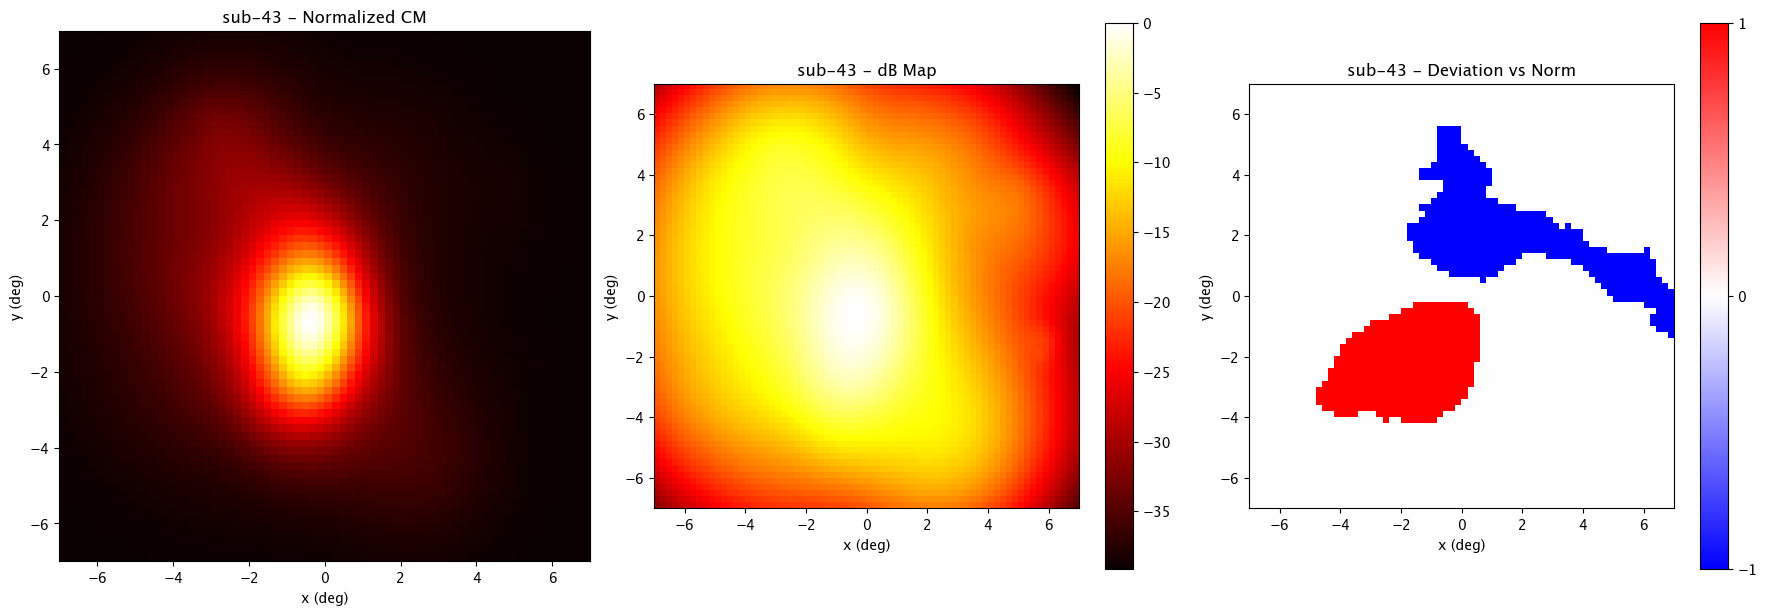

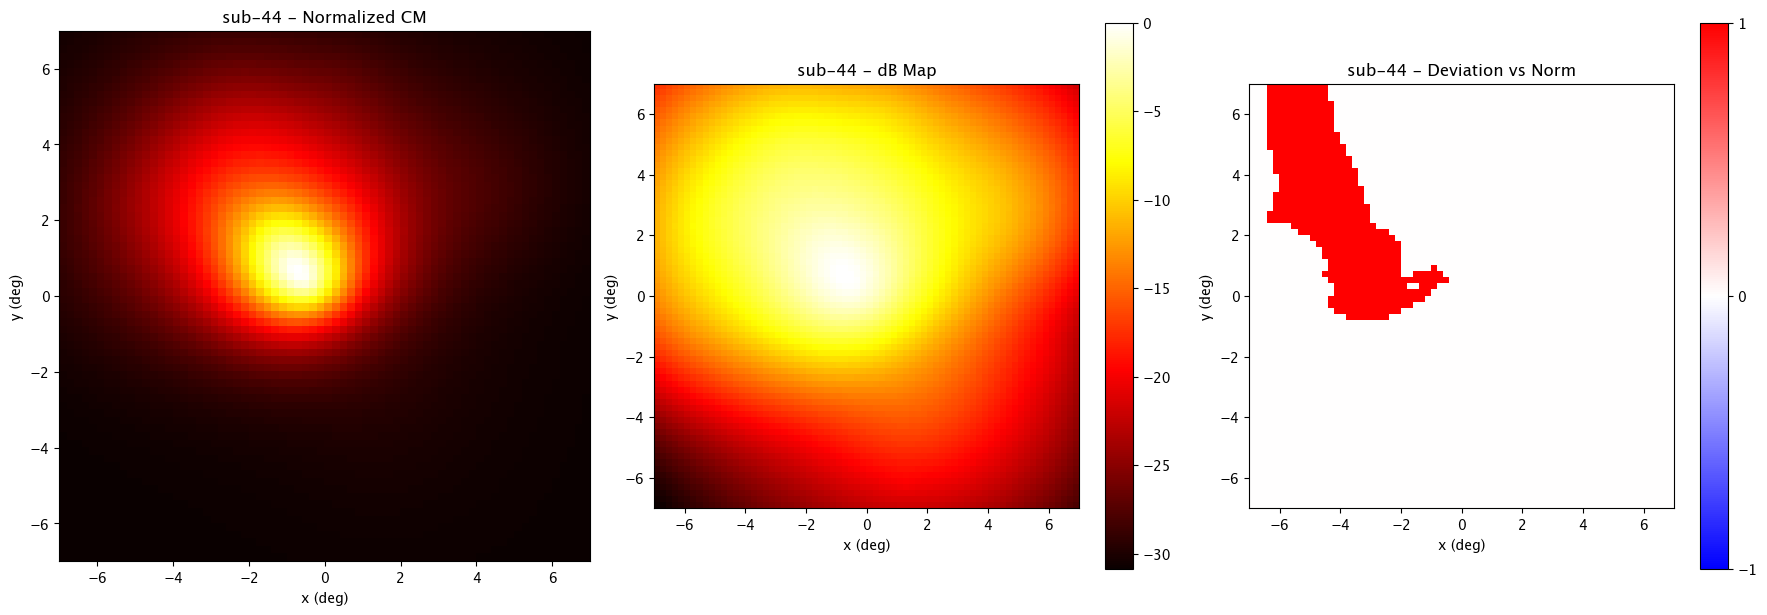

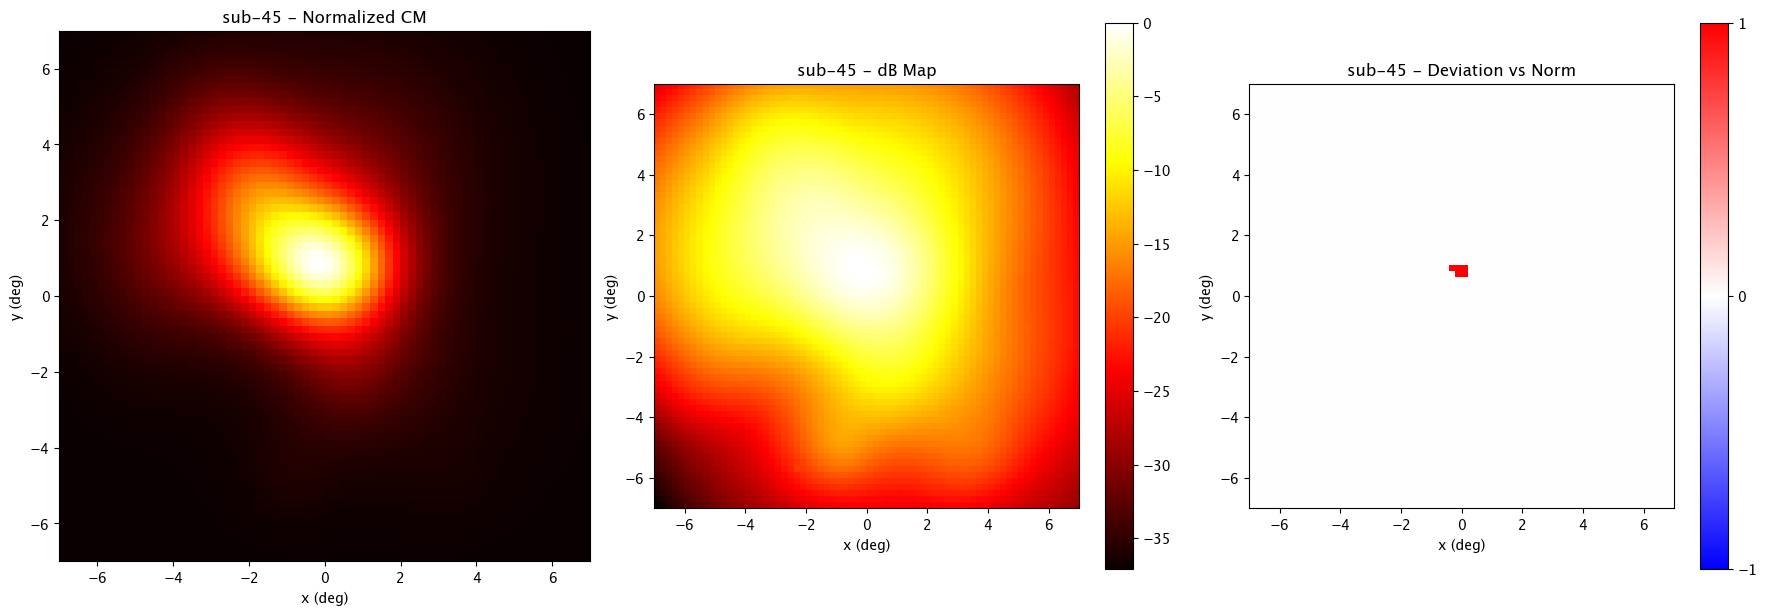

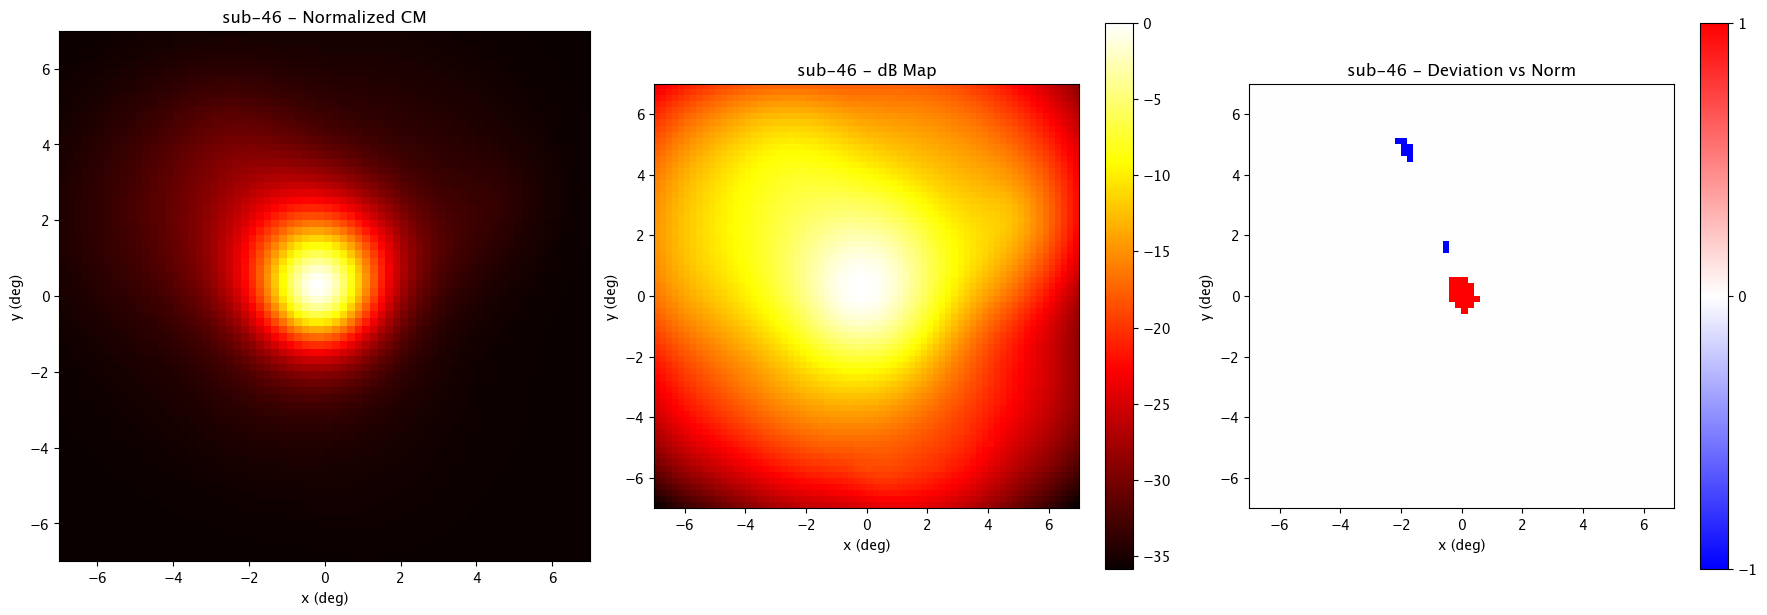

In [19]:
""" For each participant, a single coverage map was reconstructed for the left and right visual cortex ROI by 
summing the pRF models of the thresholded voxels (VE > 10%) within the ROI and by weighting them by their VE."""

# Generate a single voxel's coverage map (CM) as a 2D Gaussian, scaled by its VE.

def create_voxel_cm(x, y, sigma, ve, grid=grid, field_of_view=field_of_view):
    # # Skip voxels with poor model fit (VE below threshold) or invalid size (sigma ≤ 0)
    if r2_thr < r2_thr or sigma <= 0:
        return np.zeros((grid, grid)) # Return an empty map
    # Create a grid of visual space coordinates from -FOV to +FOV
    lin = np.linspace(-field_of_view, field_of_view, grid)
    xv, yv = np.meshgrid(lin, lin)
    # Compute the 2D Gaussian centered at (x, y) with std dev = sigma
    gauss = np.exp(-((xv - x)**2 + (yv - y)**2) / (2 * sigma**2))
    # Scale the Gaussian by the VE — voxels with higher VE contribute more
    return gauss * r2_thr

# Given a list of ROI indices and valid voxel indices, return matching voxel indices
def get_prf_indices_for_roi(roi_indices, prf_params_vx):
    # Keep only voxels whose index is in both the ROI and valid voxel list
    return [i for i, vx in enumerate(prf_params_vx) if vx in roi_indices]

# Sum the individual voxel coverage maps to generate a full ROI coverage map.
def generate_roi_cm(prf_params, roi_indices, grid=grid, field_of_view=field_of_view):
    # Extract pRF parameters: x/y location, RF size (sigma), and Variance Explained (VE)
    x, y, sigma, r2_thr = prf_params[:, 0], prf_params[:, 1], prf_params[:, 2], prf_params[:, -1]
    # Initialize an empty coverage map
    cm = np.zeros((grid, grid))
    # Compute eccentricity of each voxel (distance from center)
    eccentricity = np.sqrt(x**2 + y**2)
    # Build a mask to keep voxels within central 6.5° and with valid VE/sigma
    valid_mask = (eccentricity <= 6.5) & (r2_thr >= r2_thr) & (sigma > 0)
    # Apply the mask to the ROI indices
    valid_indices = [i for i in roi_indices if valid_mask[i]]
    # Add the weighted coverage map of each valid voxel into the total map
    for i in valid_indices:
        cm += create_voxel_cm(x[i], y[i], sigma[i], ve[i], grid, field_of_view)

    return cm

# Compute a Z-map by normalizing a subject's coverage map against the normative mean/std.
def compute_zmap(cm, norm_mean, norm_std):
    # Suppress warnings from invalid operations (like division by zero)
    with np.errstate(divide='ignore', invalid='ignore'):
        # Standard score: how far each point in the CM is from the norm
        z = (cm - norm_mean) / norm_std
        # Replace any NaN values (from 0/0 or invalid std) with 0
        z[np.isnan(z)] = 0
    return z

# Convert a normalized coverage map to dB scale using 10 × log10(cm).
def convert_to_db(cm_norm, min_val=1e-4):
    # Avoid log(0) by clipping very small values to min_val
    # Values must be in [min_val, 1] range for valid log10 conversion
    return 10 * np.log10(np.clip(cm_norm, min_val, 1))

# Visualizes three types of maps for a given subject:
#    1. Normalized Coverage Map (CM)
#    2. CM converted to dB scale
#    3. Classification of deviation compared to normative CI bounds (5%–95%)
def visualize_cm_results(subject, cm_norm, db_map, z_map, ci_5, ci_95, field_of_view=field_of_view):
    # Create a row of 3 subplots with shared size
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    # 1. Normalized CM
    # Display the normalized coverage map
    axs[0].imshow(cm_norm.T, origin='lower', cmap='hot', extent=[-field_of_view, field_of_view, -field_of_view, field_of_view])
    axs[0].set_title(f'{subject} - Normalized CM')
    # 2. dB Map (log-scaled sensitivity)
    # Display the dB map (converted to logarithmic scale)
    im1 = axs[1].imshow(db_map.T, origin='lower', cmap='hot', extent=[-field_of_view, field_of_view, -field_of_view, field_of_view])
    axs[1].set_title(f'{subject} - dB Map') # Title for subplot
    fig.colorbar(im1, ax=axs[1])  # Add colorbar to the dB map

    # 3. Deviation Classification Map
    # Create boolean masks for areas below 5th percentile and above 95th percentile
    below, above = db_map < ci_5, db_map > ci_95
    # Initialize empty classification map with zeros (i.e., "within normal limits")
    classified = np.zeros_like(db_map)
    # Assign -1 to "below normal" areas, 1 to "above normal"
    classified[below], classified[above] = -1, 1
    # Show the deviation classification map using blue–white–red (bwr) colormap
    im2 = axs[2].imshow(classified.T, origin='lower', cmap='bwr', extent=[-field_of_view, field_of_view, -field_of_view, field_of_view], vmin=-1, vmax=1)
    axs[2].set_title(f'{subject} - Deviation vs Norm')
    fig.colorbar(im2, ax=axs[2], ticks=[-1, 0, 1]) # Colorbar with -1 (low), 0 (norm), 1 (high)
    # Axis labeling for all plots
    for ax in axs:
        ax.set_xlabel('x (deg)') # X-axis label
        ax.set_ylabel('y (deg)') # Y-axis label
    # Automatically adjust spacing to avoid overlap
    plt.tight_layout()
    # Display the figure
    plt.show()

# Generate the coverage map (CM) for a single subject.

def generate_cm(subject, MAIN_PATH, denoising, atlas, model_name, depth, task, roi_masks, normalize=True):
    try:
        # Path to subject-specific pRF parameter file
        file_path = os.path.join(
            MAIN_PATH, f'pRFM/{subject}/ses-02/{denoising}/',
            f'model-{atlas}-{model_name}-{depth}_desc-prf_params_{task}.pkl'
        )
        # Load the model data
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        # Extract voxel-wise pRF parameters (x, y, sigma, VE)
        prf_params = data['model'].iterative_search_params
        # Identify voxels inside the cortical ROI mask (1 = inside ROI)
        prf_params_vx = np.where(data['rois_mask'] == 1)[0]
        # Initialize empty total coverage map
        cm_all = np.zeros((grid, grid))
        # Loop through each ROI and sum its voxels' CM contribution
        for roi_key, roi_indices in roi_masks.items():
            relevant_indices = get_prf_indices_for_roi(roi_indices, prf_params_vx)
            cm_all += generate_roi_cm(prf_params, relevant_indices)
        # Normalize to 0–1 scale (if enabled)
        if normalize and np.nanmax(cm_all) > 0:
            cm_all /= np.nanmax(cm_all)
        return cm_all

    except Exception as e:
        print(f"Error with {subject}: {e}")
        return None

# Builds the normative group-level coverage model from control subjects.
def build_normative_model(controls, MAIN_PATH, denoising, atlas, model_name, depth, task, roi_masks):
    cms = []
    for subj in controls:
        cm = generate_cm(subj, MAIN_PATH, denoising, atlas, model_name, depth, task, roi_masks)
        if cm is not None:
            cms.append(cm)
    # Abort if no valid control maps were found
    if len(cms) == 0:
        print("[ERROR] No valid CMs generated from control subjects.")
        return None, None, None

    cms = np.array(cms)
    return cms, np.nanmean(cms, axis=0), np.nanstd(cms, axis=0)

# Builds a leave-one-subject-out (LOSO) normative model for each control.
def build_normative_model_loso(controls, MAIN_PATH, denoising, atlas, model_name, depth, task, roi_masks):
    # Step 1: Generate individual CMs for all control subjects
    cm_dict = {subj: generate_cm(subj, MAIN_PATH, denoising, atlas, model_name, depth, task, roi_masks)
               for subj in controls}
    # Step 2: For each subject, calculate normative stats excluding their own CM
    loso_means = {
        subj: np.nanmean([cm for k, cm in cm_dict.items() if k != subj], axis=0)
        for subj in controls
    }
    loso_stds = {
        subj: np.nanstd([cm for k, cm in cm_dict.items() if k != subj], axis=0)
        for subj in controls
    }
    return cm_dict, loso_means, loso_stds

# Compute voxel-wise confidence intervals from control group CMs.
def compute_confidence_intervals(control_cms, percentiles=[5, 95]):
    # Convert normalized CMs to dB scale
    dbs = [convert_to_db(cm) for cm in control_cms]
    # Stack into a 3D array (subjects × X × Y)
    dbs = np.stack(dbs)
    # Return percentile maps for each requested CI bound
    return {f'{p}%': np.percentile(dbs, p, axis=0) for p in percentiles}

# Process a single subject to compute and visualize their VF coverage map, dB map, Z-score map, and CI-based deviation map.
def process_subject(subject, controls, MAIN_PATH, denoising, atlas, model_name, depth, task, roi_masks):
    # Determine whether this subject is a control or patient
    is_control = subject in controls

    if is_control:
        # For control subjects, use leave-one-subject-out normative modeling
        cm_dict, loso_means, loso_stds = build_normative_model_loso(
            controls, MAIN_PATH, denoising, atlas, model_name, depth, task, roi_masks
        )
        subject_cm = cm_dict[subject] # Get this subject's coverage map
        norm_mean = loso_means[subject] # Use group mean excluding this subject
        norm_std = loso_stds[subject] # Use group std excluding this subject
    else:
        # For patients, use group average normative model from all controls
        control_cms, norm_mean, norm_std = build_normative_model(
            controls, MAIN_PATH, denoising, atlas, model_name, depth, task, roi_masks
        )
        subject_cm = generate_cm(subject, MAIN_PATH, denoising, atlas, model_name, depth, task, roi_masks)

    # If any data is missing or failed to load, skip this subject
    if subject_cm is None or norm_mean is None or norm_std is None:
        print(f"Skipping subject {subject} due to missing data.")
        return
    # Convert the subject's normalized CM to dB scale
    subject_db = convert_to_db(subject_cm)
    # Compute the Z-score map relative to the normative model
    subject_z = compute_zmap(subject_cm, norm_mean, norm_std)
    # Compute confidence interval maps from controls
    # Use the correct source of control CMs based on subject type
    ci_maps = compute_confidence_intervals(control_cms if not is_control else list(cm_dict.values()))
    # Visualize the results (CM, dB map, classification)
    visualize_cm_results(subject, subject_cm, subject_db, subject_z, ci_maps['5%'], ci_maps['95%'])


# Example ROI mask setup (replace with your actual logic)
varea_labels = {1: 'V1', 2: 'V2', 3: 'V3'}
roi_masks = {}

for roi_val, roi_name in varea_labels.items():
    roi_masks[f'lh_{roi_name}'] = np.where((idx_vls4[:numel_left] == roi_val))[0]
    roi_masks[f'rh_{roi_name}'] = np.where((idx_vls4[numel_left:] == roi_val))[0] + numel_left

# Run processing on all subjects
for subj in all_subjects:
    process_subject(subj, controls, MAIN_PATH, denoising, atlas, model_name, depth, task, roi_masks)